<center>
    
# Εθνικό Μετσόβιο Πολυτεχνείο

## ΔΠΜΣ Επιστήμη Δεδομένων και Μηχανική Μάθηση

### Εξόρυξη Γνώσης από Δεδομένα - Εξαμηνιαία Εργασία, Χειμερινό Εξάμηνο 2019 - 2020

### London Bicycle Hires


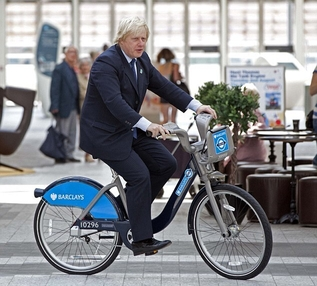


---
| Όνομα | Πρόγραμμα  |
|---------|----------|
| Καράτσαλος Χρήστος | ΔΠΜΣ $\varepsilon.\delta\varepsilon.\mu^2$ |
| Ράπτης Παναγιώτης | ΔΠΜΣ $\varepsilon.\delta\varepsilon.\mu^2$ |

---

## Data Londing + Brief Presentation of datasets being used 


* hires dataframe

* stations dataframe

* subway stations dataframe

* weather dataframe
















##### Authorization & some useful imports

In [ ]:
# necessary imports ...
!pip install -U -q PyDrive

from google.colab import auth
from google.colab import drive
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
from geopy.distance import vincenty
from prettytable import PrettyTable
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.spatial.distance import cdist, pdist
from datetime import datetime
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import LSTM, Bidirectional, GRU, Dropout, Dense
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import difflib as di
import itertools
import matplotlib.pyplot as plt
import seaborn as sn
import scipy.stats as ss
import tensorflow as tf
import matplotlib.cm as cm
import networkx as nx
import copy

auth.authenticate_user()
print("Authenticated!!")

Authenticated!!


##### Hires DataFrame

In [ ]:
# create DataFrame for hires.csv
drive.mount("/content/drive")

# read the dates correctly (parser)
dateparse = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S UTC")

df1 = pd.read_csv("/content/drive/My Drive/t/bq-results-20201017-025008-7pbvrvifia44.csv", parse_dates = ["start_date", "end_date"], date_parser = dateparse)
df2 = pd.read_csv("/content/drive/My Drive/t/bq-results-20201017-025904-8yr0hdt3m0yb.csv", parse_dates = ["start_date", "end_date"], date_parser = dateparse)
df3 = pd.read_csv("/content/drive/My Drive/t/bq-results-20201017-030222-1wgs17xtlvzn.csv", parse_dates = ["start_date", "end_date"], date_parser = dateparse)
df4 = pd.read_csv("/content/drive/My Drive/t/bq-results-20201017-030614-r331naitt4gi.csv", parse_dates = ["start_date", "end_date"], date_parser = dateparse)

hires = pd.concat([df1, df2, df3, df4]); del df1, df2, df3, df4
hires = hires.drop(["row_num"], axis = 1).reset_index(drop = True)

# print top-5 rows of hires df
hires.head(5)

#df.to_csv('df.csv')
#files.download('df.csv')

Mounted at /content/drive


,rental_id,duration,bike_id,end_date,end_station_id,end_station_name,start_date,start_station_id,start_station_name,end_station_logical_terminal,start_station_logical_terminal,end_station_priority_id
0,40346508,360,12019,2015-01-04 00:06:00,424.0,"Ebury Bridge, Pimlico",2015-01-04 00:00:00,368.0,"Harriet Street, Knightsbridge",NaN,NaN,NaN
1,40346509,660,13032,2015-01-04 00:11:00,553.0,"Regent's Row , Haggerston",2015-01-04 00:00:00,251.0,"Brushfield Street, Liverpool Street",NaN,NaN,NaN
2,40346510,420,2129,2015-01-04 00:08:00,311.0,"Foley Street, Fitzrovia",2015-01-04 00:01:00,89.0,"Tavistock Place, Bloomsbury",NaN,NaN,NaN
3,40346511,2940,12584,2015-01-04 00:50:00,495.0,"Bow Church Station, Bow",2015-01-04 00:01:00,386.0,"Moor Street, Soho",NaN,NaN,NaN
4,40346512,120,7793,2015-01-04 00:03:00,450.0,"Jubilee Street, Stepney",2015-01-04 00:01:00,443.0,"Philpot Street, Whitechapel",NaN,NaN,NaN


In [ ]:
# info for hires df (1st file from the intial raw dataset)
hires.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24369201 entries, 0 to 24369200
Data columns (total 12 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   rental_id                       int64         
 1   duration                        int64         
 2   bike_id                         int64         
 3   end_date                        datetime64[ns]
 4   end_station_id                  float64       
 5   end_station_name                object        
 6   start_date                      datetime64[ns]
 7   start_station_id                float64       
 8   start_station_name              object        
 9   end_station_logical_terminal    float64       
 10  start_station_logical_terminal  float64       
 11  end_station_priority_id         float64       
dtypes: datetime64[ns](2), float64(5), int64(3), object(2)
memory usage: 2.2+ GB


In [ ]:
# find missing values
hires = hires.replace("", np.nan)
hires = hires.replace(" ", np.nan)

hires.isna().sum()

rental_id                                0
duration                                 0
bike_id                                  0
end_date                                 0
end_station_id                      229639
end_station_name                         0
start_date                               0
start_station_id                    229639
start_station_name                       0
end_station_logical_terminal      24139562
start_station_logical_terminal    24139562
end_station_priority_id           24139562
dtype: int64

In [ ]:
# basic statistics for hires df
hires.describe()

,rental_id,duration,bike_id,end_station_id,start_station_id,end_station_logical_terminal,start_station_logical_terminal,end_station_priority_id
count,2.436920e+07,2.436920e+07,2.436920e+07,2.413956e+07,2.413956e+07,229639.000000,229639.000000,229639.000000
mean,5.317360e+07,1.332294e+03,7.309121e+03,3.432131e+02,3.461949e+02,86010.916883,86730.966251,0.260404
std,7.418510e+06,9.827994e+03,4.137050e+03,2.267200e+02,2.271306e+02,115734.282918,115945.058728,0.438856
min,4.034651e+07,-3.540000e+03,1.000000e+00,1.000000e+00,1.000000e+00,959.000000,959.000000,0.000000
25%,4.674825e+07,4.800000e+02,3.730000e+03,1.540000e+02,1.540000e+02,1092.000000,1093.000000,0.000000
50%,5.314952e+07,8.400000e+02,7.421000e+03,3.070000e+02,3.110000e+02,2696.000000,2699.000000,0.000000
75%,5.959150e+07,1.320000e+03,1.086500e+04,5.310000e+02,5.340000e+02,200116.000000,200118.000000,1.000000
max,6.606506e+07,2.674020e+06,1.497600e+04,8.250000e+02,8.250000e+02,300249.000000,300249.000000,1.000000


In [ ]:
# median for hires df (numerical data)
hires.median()

rental_id                         53149525.0
duration                               840.0
bike_id                               7421.0
end_station_id                         307.0
start_station_id                       311.0
end_station_logical_terminal          2696.0
start_station_logical_terminal        2699.0
end_station_priority_id                  0.0
dtype: float64

In [ ]:
# columns reordering (keep only certain columns)
hires = hires[["rental_id",	"bike_id", "duration", "start_date", "start_station_name", 
               "start_station_id", "end_date",	"end_station_name", "end_station_id"]]

##### Stations DataFrame (+ Subway Stations DataFrame)

In [ ]:
# create DataFrame for stations.csv
%%bigquery --project data-mining-264317 stations
SELECT  * FROM `bigquery-public-data.london_bicycles.cycle_stations`

In [ ]:
# info for station df (2nd file from the initial raw dataset)
stations.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 0 to 784
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             785 non-null    int64  
 1   installed      785 non-null    bool   
 2   latitude       785 non-null    float64
 3   locked         785 non-null    object 
 4   longitude      785 non-null    float64
 5   name           785 non-null    object 
 6   bikes_count    785 non-null    int64  
 7   docks_count    785 non-null    int64  
 8   nbEmptyDocks   785 non-null    int64  
 9   temporary      785 non-null    bool   
 10  terminal_name  785 non-null    object 
 11  install_date   704 non-null    object 
 12  removal_date   3 non-null      object 
dtypes: bool(2), float64(2), int64(4), object(5)
memory usage: 69.1+ KB


In [ ]:
# find missing values
stations = stations.replace("", np.nan)
stations = stations.replace(" ", np.nan)

stations.isna().sum()

id                 0
installed          0
latitude           0
locked             0
longitude          0
name               0
bikes_count        0
docks_count        0
nbEmptyDocks       0
temporary          0
terminal_name      0
install_date      81
removal_date     782
dtype: int64

In [ ]:
# basic statistics for stations df
stations.describe()

,id,latitude,longitude,bikes_count,docks_count,nbEmptyDocks
count,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000
mean,418.559236,51.505891,-0.128091,11.359236,26.547771,14.096815
std,243.934981,0.020128,0.054738,8.186342,8.884926,9.297976
min,1.000000,51.454753,-0.236770,0.000000,10.000000,0.000000
25%,206.000000,51.493146,-0.171185,5.000000,20.000000,7.000000
50%,423.000000,51.509224,-0.129699,11.000000,24.000000,13.000000
75%,631.000000,51.520859,-0.092940,16.000000,31.000000,20.000000
max,842.000000,51.549369,-0.002275,52.000000,64.000000,54.000000


In [ ]:
# median for stations df (numerical data)
stations.median()

id                 423.000000
installed            1.000000
latitude            51.509224
longitude           -0.129699
bikes_count         11.000000
docks_count         24.000000
nbEmptyDocks        13.000000
temporary            0.000000
terminal_name    22160.000000
dtype: float64

In [ ]:
# keep only the appropriate columns
stations = stations.drop(["bikes_count", "docks_count",	"nbEmptyDocks",	"install_date",	
                          "removal_date", "locked", "temporary", "terminal_name"], axis = 1)

In [ ]:
subway_stations = pd.read_csv("/content/drive/My Drive/t/London_stations.csv")
subway_stations.columns = ["station_name", "X", "Y", "latitude", "longitude", "zone", "postcode"]
subway_stations = subway_stations[["latitude", "longitude", "zone"]]
subway_stations = subway_stations.dropna(how = "any")

In [ ]:
# handle special cases (stations with multiple stations => keep only the lowest zone)
zone_list = ["3,4,5,6", "3,4"]
subway_stations.loc[subway_stations["zone"].isin(zone_list), "zone"] = 3

subway_stations.loc[subway_stations["zone"].isin(["1,2"]), "zone"] = 1
subway_stations.loc[subway_stations["zone"].isin(["2,3"]), "zone"] = 2
subway_stations.loc[subway_stations["zone"].isin(["5,6"]), "zone"] = 5
subway_stations.loc[subway_stations["zone"].isin(["6,7"]), "zone"] = 6

# transform zone as an int
subway_stations["zone"] = subway_stations["zone"].astype(int)

# print top-5 rows of subway_stations df
subway_stations.head(5)

,latitude,longitude,zone
0,51.531952,0.003723,3
1,51.490784,0.120272,4
2,51.508758,-0.263430,2
3,51.516887,-0.267690,3
4,51.503071,-0.280303,3


In [ ]:
# info for subway stations df (extra dataset)
subway_stations.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643 entries, 0 to 651
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   643 non-null    float64
 1   longitude  643 non-null    float64
 2   zone       643 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 20.1 KB


In [ ]:
# find missing values
subway_stations = subway_stations.replace("", np.nan)
subway_stations = subway_stations.replace(" ", np.nan)

subway_stations.isna().sum()

latitude     0
longitude    0
zone         0
dtype: int64

In [ ]:
# basic statistics for subway stations df
subway_stations.describe()

,latitude,longitude,zone
count,643.000000,643.000000,643.000000
mean,51.502279,-0.125476,3.405910
std,0.082198,0.147257,1.659044
min,51.282163,-0.611430,1.000000
25%,51.450450,-0.210736,2.000000
50%,51.509697,-0.117133,3.000000
75%,51.554424,-0.029742,4.000000
max,51.747016,0.329952,9.000000


In [ ]:
# median for subway stattions df
subway_stations.median()

latitude     51.509697
longitude    -0.117133
zone          3.000000
dtype: float64

In [ ]:
# find the zone of the nearest metro station, for each bike station, and the relative distance (measured in meters)
def findZone(row):
  distance_list = [vincenty((row.latitude, row.longitude), (r.latitude, r.longitude)).meters for idx, r in subway_stations.iterrows()]
  i = np.argmin(distance_list)
  return int(subway_stations.iloc[i]["zone"]), float(round(distance_list[i], 3))

# find  zone & distance for each bike station, based on its nearest subway station
stations["zone"], stations["distance"], stations["distance_category"] = None, None, None
for index, row in stations.iterrows():
  stations.at[index, "zone"], stations.at[index, "distance"] = findZone(row)

# fill in the categorical feature of "distance category", based on the following thresholding
stations.loc[stations["distance"] <= 300, "distance_category"] = "Very Close"
stations.loc[stations["distance"] > 300, "distance_category"] = "Close"
stations.loc[stations["distance"] > 700, "distance_category"] = "Long"

# print top-5 rows of stations df
stations.head(5)

,id,installed,latitude,longitude,name,zone,distance,distance_category
0,215,True,51.519069,-0.088285,"Moorfields, Moorgate",1,86.781,Very Close
1,378,True,51.495593,-0.179078,"Natural History Museum, South Kensington",1,333.152,Close
2,682,True,51.488108,-0.226606,"Crisp Road, Hammersmith",2,488.037,Close
3,12,True,51.521681,-0.130432,"Malet Street, Bloomsbury",1,326.131,Close
4,126,True,51.517821,-0.096497,"Museum of London, Barbican",1,279.572,Very Close


In [ ]:
print("The min distance between a bike station and its nearest subway station is: ", min(stations.distance), "m!")
print("The max distance between a bike station and its nearest subway station is: ", max(stations.distance), "m!")

The min distance between a bike station and its nearest subway station is:  15.539 m!
The max distance between a bike station and its nearest subway station is:  1157.638 m!


##### Weather DataFrame

In [ ]:
# authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# new parser for weather df
dateparse = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S +0000 UTC")

# load london weather (from google drive) as a df
link = "https://drive.google.com/file/d/1bk7cVtE9-3eCr-ws-8xS0qly3KuV9iaN/view?usp=sharing"
fluff, id = link.split("=")
downloaded = drive.CreateFile({"id":"1bk7cVtE9-3eCr-ws-8xS0qly3KuV9iaN"}) 
downloaded.GetContentFile("london_weather.csv")  
weather = pd.read_csv("london_weather.csv", parse_dates = ["dt_iso"], date_parser = dateparse)

# select the appropriate features
weather = weather[["dt_iso", "temp", "pressure", "humidity", "wind_speed", "weather_main"]]

# print top-5 rows of weather df
weather.head(5)

,dt_iso,temp,pressure,humidity,wind_speed,weather_main
0,2015-01-01 00:00:00,4.78,1033.2,84,4.1,Clouds
1,2015-01-01 01:00:00,4.98,1032.9,85,4.1,Clouds
2,2015-01-01 02:00:00,5.76,1031.9,85,3.6,Clouds
3,2015-01-01 03:00:00,6.06,1032.4,88,2.6,Clouds
4,2015-01-01 04:00:00,6.52,1032.1,89,3.6,Clouds


In [ ]:
# info for weather df (extra dataset)
weather.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35093 entries, 0 to 35092
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dt_iso        35093 non-null  object 
 1   temp          35093 non-null  float64
 2   pressure      35093 non-null  float64
 3   humidity      35093 non-null  int64  
 4   wind_speed    35093 non-null  float64
 5   weather_main  35093 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 1.6+ MB


In [ ]:
# find missing values
weather = weather.replace("", np.nan)
weather = weather.replace(" ", np.nan)

weather.isna().sum()

dt_iso          0
temp            0
pressure        0
humidity        0
wind_speed      0
weather_main    0
dtype: int64

In [ ]:
# basic statistics for weather df (more meaningful stats in comparsion with the previous ones)
weather.describe()

,temp,pressure,humidity,wind_speed
count,35093.000000,35093.000000,35093.000000,35093.000000
mean,11.656913,1016.786781,75.734050,3.954441
std,5.980484,10.230284,16.255842,2.216761
min,-6.200000,970.000000,17.000000,0.080000
25%,7.270000,1011.100000,65.000000,2.100000
50%,11.490000,1017.900000,79.000000,3.600000
75%,15.800000,1023.400000,89.000000,5.100000
max,33.700000,1046.300000,100.000000,18.000000


In [ ]:
# median for weather df
weather.median()

temp            11.49
pressure      1017.90
humidity        79.00
wind_speed       3.60
dtype: float64

## Preprocessing

* Validation - Correction of the dataframes

* Remove Duration/Stations Outliers

* Feature Generation

* Merge the final editions of hires and stations dataframes + keep only the useful columns









In [ ]:
# float (stations') id -> int id + NaN -> 0
hires["start_station_id"] = hires["start_station_id"].fillna(0.0).astype(int)
hires["end_station_id"] = hires["end_station_id"].fillna(0.0).astype(int)

In [ ]:
hires = hires.loc[hires["duration"] > 60] # delete hires with duration < 60sec

# throw away hires with duration not in [q1-1.5*iqr, q3+1.5*iqr] (outliers)
q1 = hires["duration"].quantile(0.25)
q3 = hires["duration"].quantile(0.75)
iqr = q3 - q1
hires = hires.query("(@q1 - 1.5 * @iqr) <= duration <= (@q3 + 1.5 * @iqr)")

In [ ]:
start_ids = hires.start_station_id.unique(); end_ids = hires.end_station_id.unique()

hires_ids = np.unique(np.concatenate((start_ids, end_ids), 0))
stations_ids = stations.id.unique()

# remove stations with 0 hires
stations = stations[~stations["id"].isin(list(np.setdiff1d(stations_ids, hires_ids)))]

# romove hires which having start_station_id not in stations.csv
hires = hires[~hires["start_station_id"].isin(list(np.setdiff1d(hires_ids, stations_ids)))]

# remove hires which having end_station_id not in stations.csv
hires = hires[~hires["end_station_id"].isin(list(np.setdiff1d(hires_ids, stations_ids)))]

In [ ]:
# merge with weather data
hires["start_time_weather"] = hires["start_date"]
hires["start_time_weather"] = hires["start_time_weather"].dt.floor("h")
hires = pd.merge(left = weather, right = hires, left_on = "dt_iso", right_on = "start_time_weather")

# columns reordering
hires = hires[["rental_id",	"bike_id", "duration", "start_date", "start_station_name", 
               "start_station_id", "end_date",	"end_station_name", "end_station_id",	
               "temp",	"pressure","humidity", "wind_speed",	"weather_main", "start_time_weather"]]

hires["week_day"] = hires["start_date"].dt.dayofweek

In [ ]:
# create some extra useful features, based on the available data
hires["year"] = hires["start_date"].dt.year
hires["month"] = hires["start_date"].dt.month
hires["day"] = hires["start_date"].dt.day
hires["hour"] = hires["start_date"].dt.hour

# keep only hires in 2016 year!
# We'll discuss only for 2016; otherwise we'd have problems with available RAM
hires = hires.loc[hires["year"] == 2016]

In [ ]:
# holidays from 2015 to 2017 (by hand...)
hires["weekend_or_holiday"] = 0

# weekends => True
hires.loc[hires["week_day"].isin([5, 6]), "weekend_or_holiday"] = 1

holidays_list = ["2015-04-03", "2015-04-06", "2015-05-04", "2015-05-25", "2015-08-31", "2015-12-25", "2015-12-28", "2016-01-01", "2016-03-25", "2016-05-02", 
                 "2016-05-30", "2016-08-29", "2016-12-25", "2016-12-26", "2017-01-02", "2017-04-14", "2017-05-17", "2017-05-01", "2017-05-29", "2017-08-28"]

# holidays => true
hires.loc[hires["start_date"].dt.strftime("%Y-%m-%d").isin(holidays_list), "weekend_or_holiday"] = 1

In [ ]:
hires["time_seg"] = None

# masking for Night period
mask1 = ((hires.hour >=0) & (hires.hour <= 6)) | (hires.hour >= 22)

# for Morning period
mask2 = (hires.hour >= 7) & (hires.hour <= 13)

# for Afternoon period
mask3 = (hires.hour >= 14) & (hires.hour <= 16)

# for evening
mask4 =  (hires.hour >= 17) & (hires.hour <= 21)

hires.loc[mask1, "time_seg"] = "Night"
hires.loc[mask2, "time_seg"] = "Morning"
hires.loc[mask3, "time_seg"] = "Afternoon"
hires.loc[mask4, "time_seg"] = "Evening"

In [ ]:
hires["season"] = None
mask1 = (hires.month >= 2) & (hires.month <= 4)
mask2 = (hires.month >= 5) & (hires.month <= 7)
mask3 = (hires.month >= 8) & (hires.month <= 10)
mask4 = (hires.month >= 11) | (hires.month == 1)

# masking for Spring period
hires.loc[mask1, "season"] = "Spring"

# for Summer period
hires.loc[mask2, "season"] = "Summer"

# for Autum period
hires.loc[mask3, "season"] = "Autum"

# for Winter period
hires.loc[mask4, "season"] = "Winter"

In [ ]:
# add start_station_latitude, start_station_longitude into hires df
hires = pd.merge(left = stations, right = hires, left_on = "id", right_on = "start_station_id")

hires = hires[["rental_id", "bike_id", "duration", "start_station_name", "start_station_id",	"latitude",	
               "longitude", "zone", "distance_category", "start_date", "end_station_name", "end_station_id", "end_date", "temp", 
               "humidity", "pressure",	"wind_speed",	"weather_main",	"start_time_weather", "week_day",	
               "weekend_or_holiday",	"year",	"month",	"day", "hour", "time_seg", "season"]]

hires.columns =  ["rental_id", "bike_id", "duration", "start_station_name", "start_station_id",	"start_station_latitude",	
                  "start_station_longitude", "start_station_zone", "start_station_distance", "start_date", "end_station_name", "end_station_id", "end_date", "temperature", 
                  "humidity",	"pressure", "wind_speed",	"weather_main_condition",	"start_time_weather",	"week_day",	
                  "weekend_or_holiday",	"year",	"month",	"day", "hour", "time_seg", "season"]

In [ ]:
hires = pd.merge(left = stations, right = hires, left_on = "id", right_on = "end_station_id") # add end_station_latitude, end_station_longitude into hires df

hires = hires[["rental_id", "duration", "start_station_name", "start_station_id", "start_station_latitude", 
               "start_station_longitude", "start_station_zone", "start_station_distance", "start_date", "end_station_name", 
               "end_station_id", "latitude", "longitude", "zone", "distance_category", "end_date", "temperature", "pressure", "humidity",	"wind_speed",	
               "weather_main_condition", "start_time_weather",	"week_day",	"weekend_or_holiday",	"year",	"month", "day", "hour", "time_seg", "season"]]

hires.columns = ["rental_id", "duration", "start_station_name", "start_station_id",	"start_station_latitude",
                 "start_station_longitude", "start_station_zone", "start_station_distance", "start_date", "end_station_name", 
                 "end_station_id", "end_station_latitude", "end_station_longitude", "end_station_zone", "end_station_distance", "end_date", "temperature", "pressure", "humidity",	"wind_speed",	
                 "weather_main_condition", "start_day", "week_day",	"weekend_or_holiday",	"year",	"month",	"day", "hour", "time_seg", "season"]

In [ ]:
# minimal info for stations
mini_stations = stations[["id", "name", "latitude", "longitude"]].drop_duplicates(). \
rename(columns = {"id": "station_id", "name": "station_name", "latitude": "station_latitude", "longitude": "station_longitude"})

# sorting the hires df by start_date
hires = hires.sort_values(by = "start_date", ascending = True)
hires = hires.reset_index(drop = True)

In [ ]:
# check if all stations have one-to-one matching between their id and name
a = len(hires["start_station_id"].unique())
b = len(hires[["start_station_id", "start_station_name"]].drop_duplicates())
c = len(hires["end_station_id"].unique())
d = len(hires[["end_station_id", "end_station_name"]].drop_duplicates())

print("Have all stations 1-1 matching among their id and their name? ", "Yes" if a == b and c == d else "No")

Have all stations 1-1 matching among their id and their name?  No


In [ ]:
# check if all stations have one-to-one matching between their id and latitude
a = len(hires["start_station_id"].unique())
b = len(hires[["start_station_id", "start_station_latitude"]].drop_duplicates())
c = len(hires["end_station_id"].unique())
d = len(hires[["end_station_id", "end_station_latitude"]].drop_duplicates())

print("Have all stations 1-1 matching among their id and their latitude? ", "Yes" if a == b and c == d else "No")

Have all stations 1-1 matching among their id and their latitude?  Yes


In [ ]:
# check if all stations have one-to-one matching between their id and longitude
a = len(hires["start_station_id"].unique())
b = len(hires[["start_station_id", "start_station_longitude"]].drop_duplicates())
c = len(hires["end_station_id"].unique())
d = len(hires[["end_station_id", "end_station_longitude"]].drop_duplicates())

print("Have all stations 1-1 matching among their id and their longitude? ", "Yes" if a == b and c == d else "No")

Have all stations 1-1 matching among their id and their longitude?  Yes


In [ ]:
hires["start_seg"] = hires["start_date"].round("30min")
hires["stop_seg"] = hires["end_date"].round("30min")

# columns reordering
hires = hires[["rental_id",	"duration",	"start_station_name",	"start_station_id",	"start_station_latitude",	"start_station_longitude",	"start_station_zone", "start_station_distance",
               "start_date", "start_seg", "end_station_name",	"end_station_id",	"end_station_latitude",	"end_station_longitude",	"end_station_zone",	"end_station_distance",	
               "end_date",	"stop_seg", "temperature",	"pressure",	"humidity",	"wind_speed",	"weather_main_condition",	"start_day",	"week_day",	"weekend_or_holiday",	"year",	
               "month",	"day",	"hour",	"time_seg",	"season"]]


# construct dfs per each station, for inflow & outglow
inflow = hires[["end_station_id", "stop_seg"]].groupby(["end_station_id", "stop_seg"]).size().reset_index(name = "counts") \
            .rename(columns = {"end_station_id": "station_id", "stop_seg": "time", "counts": "in_flow_count"})

outflow = hires[["start_station_id", "start_seg"]].groupby(["start_station_id", "start_seg"]).size().reset_index(name = "counts") \
            .rename(columns = {"start_station_id": "station_id", "start_seg": "time", "counts": "out_flow_count"})

station_id_list = list(mini_stations["station_id"])

time_seg_list = list(pd.date_range("2016-01-01 00:00:00", "2016-12-31 23:00:00", freq = "60min"))
temp = pd.DataFrame(list(itertools.product(station_id_list, time_seg_list)), columns = ["station_id", "time"])

# merge in/out-flow information
dat = pd.merge(inflow, outflow, on=["station_id", "time"], how = "outer")
dat["time"] = pd.to_datetime(dat["time"], format = "%Y-%m-%d %H:%M")
dat = dat.merge(temp, on = ["station_id", "time"], how = "right").fillna(0) # add zeros to missing data

## Data Exploration

##### Final form of hires df (include the larger part of necessary information)

In [ ]:
# 1st row of hires csv
hires.loc[0]

rental_id                                    50608187
duration                                         1200
start_station_name            Chelsea Bridge, Pimlico
start_station_id                                  419
start_station_latitude                        51.4858
start_station_longitude                     -0.149004
start_station_zone                                  1
start_station_distance                           Long
start_date                        2016-01-01 00:04:00
start_seg                         2016-01-01 00:00:00
end_station_name           Rochester Row, Westminster
end_station_id                                    118
end_station_latitude                          51.4958
end_station_longitude                       -0.135478
end_station_zone                                    1
end_station_distance                            Close
end_date                          2016-01-01 00:24:00
stop_seg                          2016-01-01 00:30:00
temperature                 

##### Distributions of the Data

In [ ]:
# hiresAg df (Ag stands for Aggregation per hour)
hiresAg = hires[["year",	"month",	"day", "start_day", "hour", "week_day","duration", "season", "weekend_or_holiday"]] \
.groupby(["year",	"month",	"day", "start_day", "week_day",	"hour", "season", "weekend_or_holiday"], as_index = False).agg(["count", "mean"])

# again sorting
hiresAg = hiresAg.sort_values(by = ["year",	"month",	"day"], ascending = True)

# pretty print
mylist = list(map(int, hiresAg["duration"].values[:, 0]))
hiresAg["counts"] = mylist

mylist = list(hiresAg["duration"].values[:, 1])
hiresAg["avg_duration"] = mylist; del hiresAg["duration"]
hiresAg = hiresAg.reset_index()

In [ ]:
# merging with weather (hourly) data
hiresAg = pd.merge(left = weather, right = hiresAg, left_on = "dt_iso", right_on = "start_day")

# change columns name
hiresAg.columns = ["dt_iso", "temperature", "pressure",	"humidity",	"wind_speed",	"weather_main", "year", "month", "day", "start_day", "week_day", "hour",
                    "season", "weekend_or_holiday", "counts", "avg_duration"]

# delete dt_iso column
hiresAg = hiresAg[["temperature", "pressure",	"humidity",	"wind_speed",	"weather_main", "year", "month", "day", "start_day", "week_day", "hour",
                    "season", "weekend_or_holiday", "counts", "avg_duration"]]
# print top-5 rows of hiresAg df
hiresAg.head(5)

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,temperature,pressure,humidity,wind_speed,weather_main,year,month,day,start_day,week_day,hour,season,weekend_or_holiday,counts,avg_duration
0,4.96,1021.4,88,2.6,Clear,2016,1,1,2016-01-01 00:00:00,4,0,Winter,1,1250,1183.296000
1,4.96,1021.4,88,2.6,Clear,2016,1,1,2016-01-01 00:00:00,4,0,Winter,1,1250,1183.296000
2,4.24,1022.3,89,1.5,Clear,2016,1,1,2016-01-01 01:00:00,4,1,Winter,1,510,1075.529412
3,3.12,1022.6,93,1.0,Clear,2016,1,1,2016-01-01 02:00:00,4,2,Winter,1,322,1011.242236
4,2.81,1023.1,97,0.5,Clear,2016,1,1,2016-01-01 03:00:00,4,3,Winter,1,254,960.236220


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

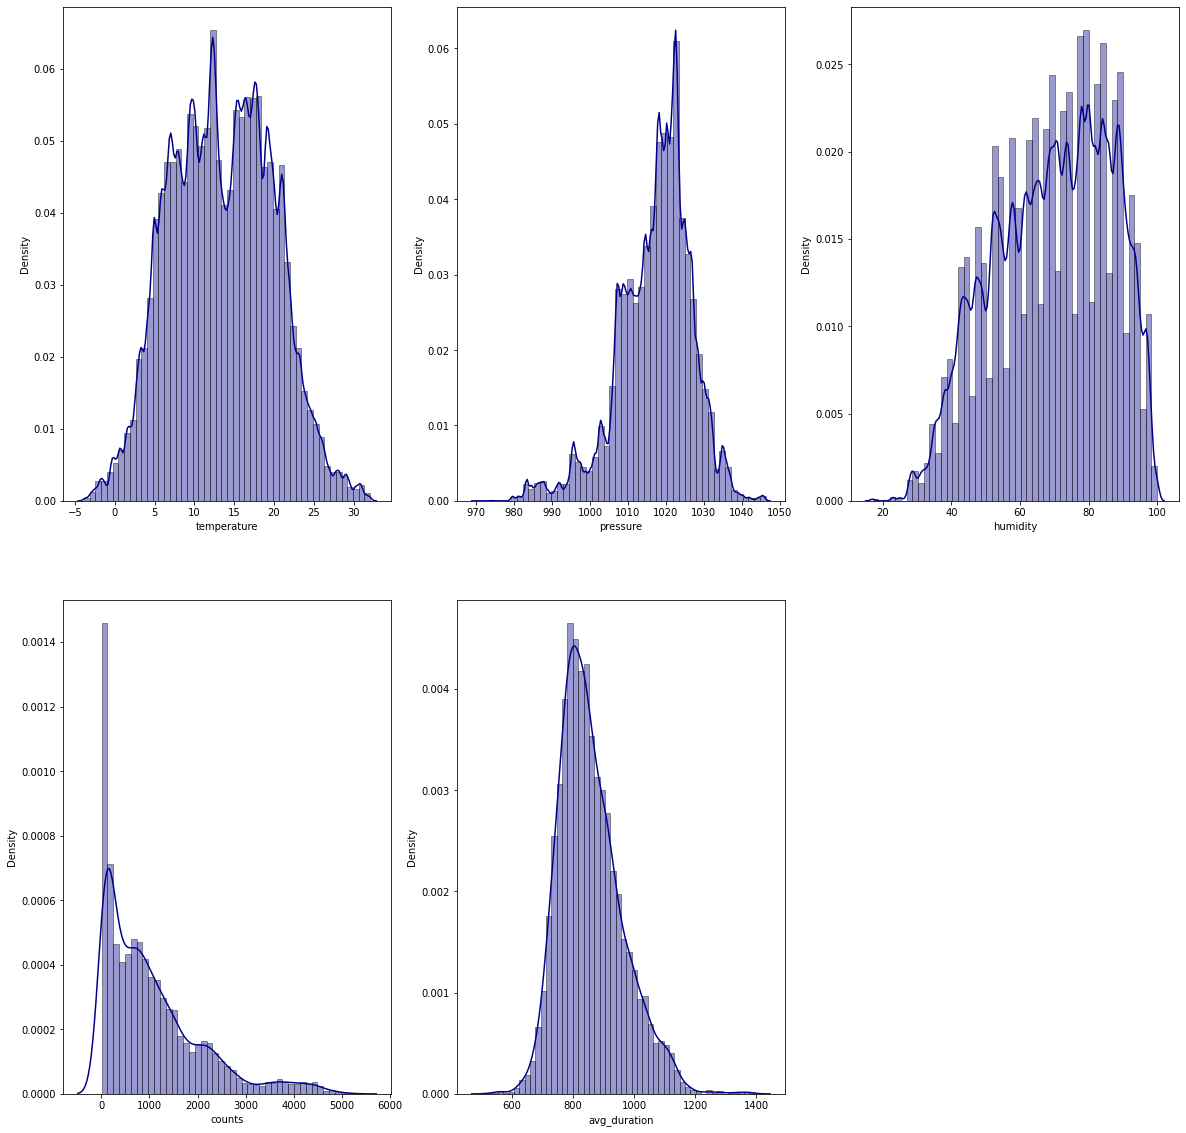

In [ ]:
# plot distributions of some numerical features
numerical_features = ["temperature",	"pressure",	"humidity", "counts", "avg_duration"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (20, 10))
fig.delaxes(axes[1,2])

for i in range(len(numerical_features)):
  if i <= 2:
    sn.distplot(hires[numerical_features[i]], fit = norm, hist = True, kde = True, color = "darkblue", hist_kws = {"edgecolor": "black"}, ax = axes[i // 3, i % 3])
  else:
    sn.distplot(hiresAg[numerical_features[i]], hist = True, kde = True, color = "darkblue", hist_kws = {"edgecolor": "black"}, ax = axes[i // 3, i % 3])

In [ ]:
# transform appropriate features as categories & plot again infos for the df
categorical_features = ["weather_main_condition", "month", "day", "week_day", "hour", "season", "weekend_or_holiday"]
hires = hires.apply(lambda x: x.astype("category") if x.name in categorical_features else x)
hires.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9004137 entries, 0 to 9004136
Data columns (total 32 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   rental_id                int64         
 1   duration                 int64         
 2   start_station_name       object        
 3   start_station_id         int64         
 4   start_station_latitude   float64       
 5   start_station_longitude  float64       
 6   start_station_zone       object        
 7   start_station_distance   object        
 8   start_date               datetime64[ns]
 9   start_seg                datetime64[ns]
 10  end_station_name         object        
 11  end_station_id           int64         
 12  end_station_latitude     float64       
 13  end_station_longitude    float64       
 14  end_station_zone         object        
 15  end_station_distance     object        
 16  end_date                 datetime64[ns]
 17  stop_seg                 da

In [ ]:
# plot distributions of categorical features
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize=(60, 60))
fig.delaxes(axes[1,3])
for i, column in enumerate(categorical_features):
    sn.countplot(hires[column], ax = axes[i // 4, i % 4])

##### Outlier Analysis

[Text(0, 0.5, 'Demand'),
 Text(0.5, 0, 'Weekend or Holiday'),
 Text(0.5, 1.0, 'Box Plot On Demand Across Working Day')]

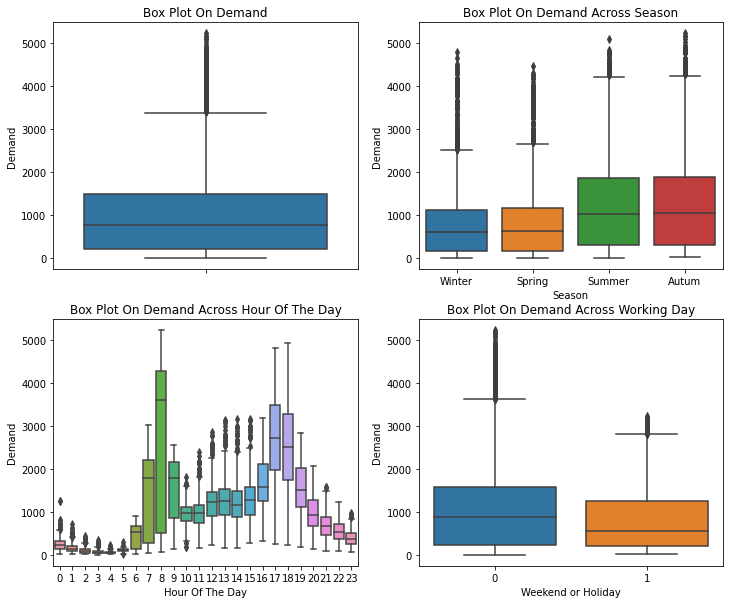

In [ ]:
# Outlier Analysis for counts per hour
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(12, 10)
sn.boxplot(data = hiresAg, y = "counts", orient = "v", ax=axes[0][0])
sn.boxplot(data = hiresAg, y = "counts", x = "season", orient = "v", ax = axes[0][1])
sn.boxplot(data = hiresAg, y = "counts", x = "hour", orient = "v", ax = axes[1][0])
sn.boxplot(data = hiresAg, y = "counts", x = "weekend_or_holiday", orient = "v", ax = axes[1][1])

axes[0][0].set(ylabel = "Demand",title = "Box Plot On Demand")
axes[0][1].set(xlabel = "Season", ylabel = "Demand",title = "Box Plot On Demand Across Season")
axes[1][0].set(xlabel = "Hour Of The Day", ylabel = "Demand", title = "Box Plot On Demand Across Hour Of The Day")
axes[1][1].set(xlabel = "Weekend or Holiday", ylabel = "Demand", title = "Box Plot On Demand Across Working Day")

##### Correlation Analysis

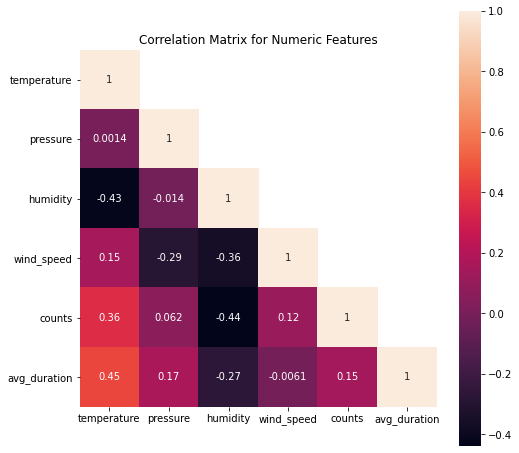

In [ ]:
# plot correlation matrix (for numerical data)
correlation_matrix = hiresAg[["temperature", "pressure",	"humidity",	"wind_speed",	"counts", "avg_duration"]].corr()

# pretty print
mask = np.array(correlation_matrix)
mask[np.tril_indices_from(mask)] = False

fig, ax= plt.subplots(figsize = (8, 8))
plt.title("Correlation Matrix for Numeric Features")
sn.heatmap(correlation_matrix, mask = mask, square = True, annot = True)

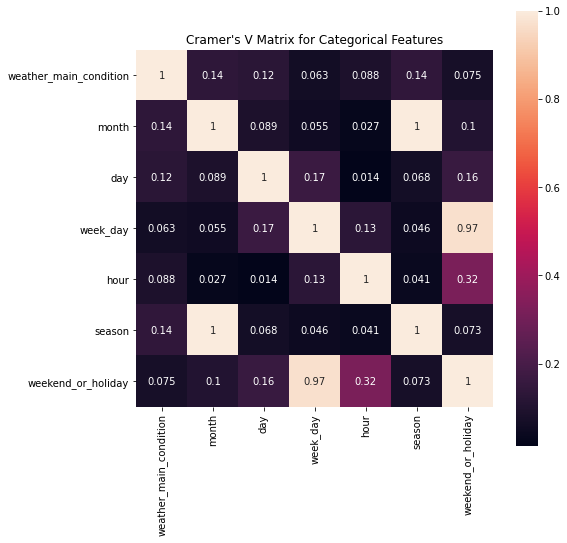

In [ ]:
# compute Cramer V matric for 2 given columns
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return float(np.sqrt(phi2corr/min((kcorr-1),(rcorr-1))))

# right dimensions of cramer's v matrix
cramer_matrix = pd.DataFrame(index = categorical_features, columns = categorical_features)

# fill in the Cramer's V Matrix
for i, column1 in enumerate(categorical_features):
    for j, column2 in enumerate(categorical_features):
      cramer_matrix[column1][column2] = cramers_v(hires[column1], hires[column2])

cramer_matrix = cramer_matrix.astype("float64")

# plotting
fig, ax= plt.subplots(figsize = (8,8))
plt.title("Cramer's V Matrix for Categorical Features")
sn.heatmap(cramer_matrix, square = True, annot = True)

##### Useful Visualazations

[Text(0, 0.5, 'Duration'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Average Duration for each Month')]

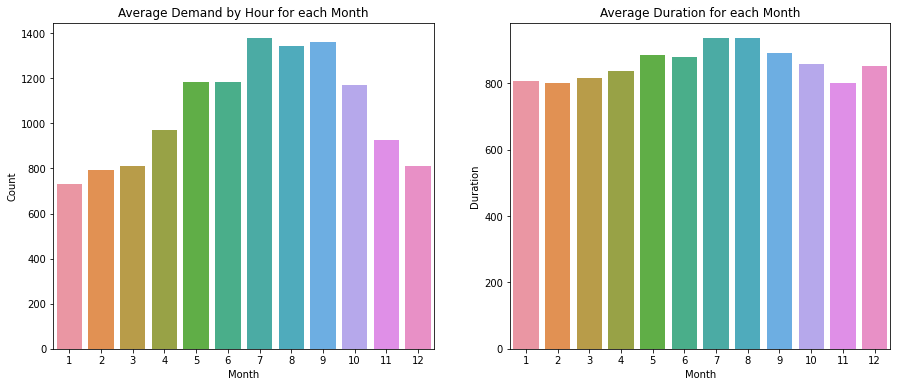

In [ ]:
# Average Demand by Hour of the day for each month
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(15, 6)
hiresAg_month = pd.DataFrame(hiresAg.groupby("month")["counts"].mean()).reset_index()
sn.barplot(data = hiresAg_month, x = "month", y = "counts", ax = ax1)
ax1.set(xlabel = "Month", ylabel = "Count", title = "Average Demand by Hour for each Month")

# Average Duration by Hour of the day for reach month
hiresAg_month = pd.DataFrame(hiresAg.groupby("month")["avg_duration"].mean()).reset_index()
sn.barplot(data = hiresAg_month, x = "month", y = "avg_duration", ax = ax2)
ax2.set(xlabel = "Month", ylabel = "Duration", title = "Average Duration for each Month")

[Text(0, 0.5, 'Duration'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Duration by Hour for Seasons')]

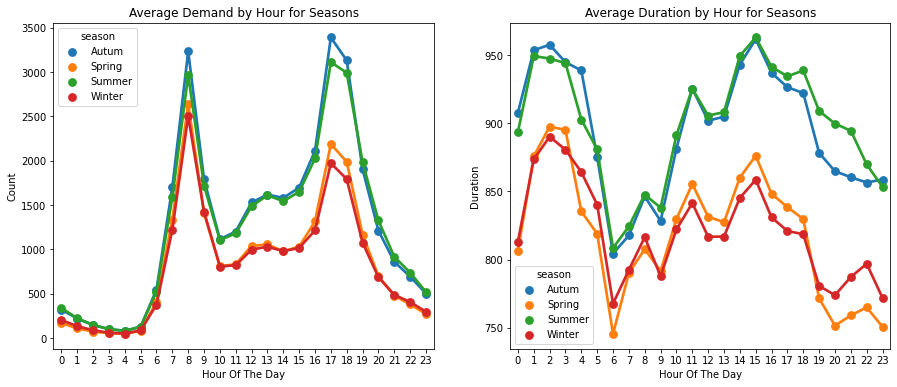

In [ ]:
# Average Demand by Hour of the day accross different seasons
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(15, 6)
hiresAg_hour = pd.DataFrame(hiresAg.groupby(["hour","season"], sort = True)["counts"].mean()).reset_index()
sn.pointplot(x = hiresAg_hour["hour"], y = hiresAg_hour["counts"], hue = hiresAg_hour["season"], data = hiresAg_hour, join = True, ax = ax1)
ax1.set(xlabel = "Hour Of The Day", ylabel = "Count", title = "Average Demand by Hour for Seasons")

# Average Duration by Hour of the day accross accross different seasons
hiresAg_hour = pd.DataFrame(hiresAg.groupby(["hour","season"], sort = True)["avg_duration"].mean()).reset_index()
sn.pointplot(x = hiresAg_hour["hour"], y = hiresAg_hour["avg_duration"], hue = hiresAg_hour["season"], data = hiresAg_hour, join = True, ax = ax2)
ax2.set(xlabel = "Hour Of The Day", ylabel = "Duration", title = "Average Duration by Hour for Seasons")

[Text(0, 0.5, 'Duration'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Duration by Hour for weekdays and weekends/holidays')]

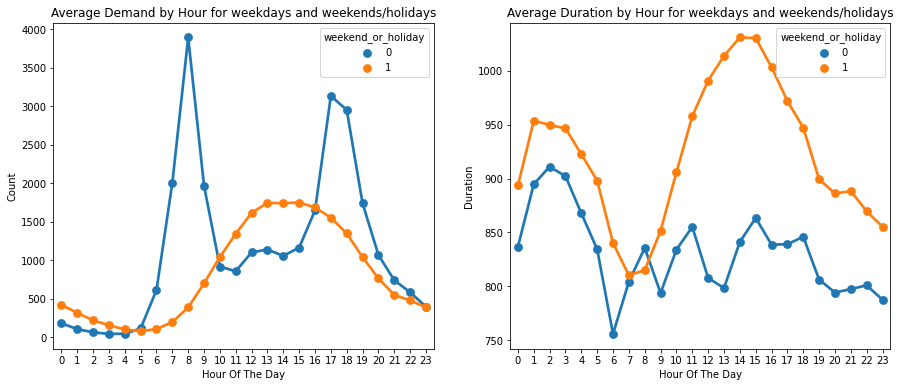

In [ ]:
# Average Demand by Hour of the day accross weekdays and weekends/holidays
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(15, 6)
hiresAg_hour = pd.DataFrame(hiresAg.groupby(["hour","weekend_or_holiday"], sort = True)["counts"].mean()).reset_index()
sn.pointplot(x = hiresAg_hour["hour"], y = hiresAg_hour["counts"], hue = hiresAg_hour["weekend_or_holiday"], data = hiresAg_hour, join = True, ax = ax1)
ax1.set(xlabel = "Hour Of The Day", ylabel = "Count", title = "Average Demand by Hour for weekdays and weekends/holidays")

# Average Duration by Hour of the day accross weekdays and weekends/holidays
hiresAg_hour = pd.DataFrame(hiresAg.groupby(["hour","weekend_or_holiday"], sort = True)["avg_duration"].mean()).reset_index()
sn.pointplot(x = hiresAg_hour["hour"], y = hiresAg_hour["avg_duration"], hue = hiresAg_hour["weekend_or_holiday"], data = hiresAg_hour, join = True, ax = ax2)
ax2.set(xlabel = "Hour Of The Day", ylabel = "Duration", title = "Average Duration by Hour for weekdays and weekends/holidays")

In [ ]:
# starting from Zone A...
mini_hires = hires.loc[hires["start_station_zone"] == 1]
hiresAg = mini_hires[["month",	"day", "start_day", "week_day", "hour", "duration"]] \
.groupby(["month",	"day", "start_day", "week_day",	"hour"], as_index = False).agg(["count", "mean"]).reset_index()

# again sorting
hiresAg = hiresAg.sort_values(by = ["month",	"day"], ascending = True)

# pretty print
mylist = list(map(int, hiresAg["duration"].values[:, 0]))
hiresAg["counts"] = mylist

mylist = list(hiresAg["duration"].values[:, 1])
hiresAg["avg_duration"] = mylist; del hiresAg["duration"]
hiresAg = hiresAg.reset_index()

# create the new df
temp_hiresAg_month = pd.DataFrame(hiresAg.groupby("month")["counts"].mean()).reset_index()
temp_hiresAg_month2 = pd.DataFrame(hiresAg.groupby("month")["avg_duration"].mean()).reset_index()
hiresAg_month_start = temp_hiresAg_month
hiresAg_month_start.columns = ["month", "Avg Demand starting from Zone A"]
hiresAg_month_start["Avg Duration starting from Zone A"] = temp_hiresAg_month2["avg_duration"]

# starting from Zone B...
mini_hires = hires.loc[hires["start_station_zone"] == 2]
hiresAg = mini_hires[["month",	"day", "start_day", "week_day", "hour", "duration"]] \
.groupby(["month",	"day", "start_day", "week_day",	"hour"], as_index = False).agg(["count", "mean"]).reset_index()

# again sorting
hiresAg = hiresAg.sort_values(by = ["month",	"day"], ascending = True)

# pretty print
mylist = list(map(int, hiresAg["duration"].values[:, 0]))
hiresAg["counts"] = mylist

mylist = list(hiresAg["duration"].values[:, 1])
hiresAg["avg_duration"] = mylist; del hiresAg["duration"]
hiresAg = hiresAg.reset_index()

temp_hiresAg_month = pd.DataFrame(hiresAg.groupby("month")["counts"].mean()).reset_index()
temp_hiresAg_month2 = pd.DataFrame(hiresAg.groupby("month")["avg_duration"].mean()).reset_index()
hiresAg_month_start["Avg Demand starting from Zone B"] = temp_hiresAg_month["counts"]
hiresAg_month_start["Avg Duration starting from Zone B"] = temp_hiresAg_month2["avg_duration"]

# starting from Zone C...
mini_hires = hires.loc[hires["start_station_zone"] == 3]
hiresAg = mini_hires[["month",	"day", "start_day", "week_day", "hour", "duration"]] \
.groupby(["month",	"day", "start_day", "week_day",	"hour"], as_index = False).agg(["count", "mean"]).reset_index()

# again sorting
hiresAg = hiresAg.sort_values(by = ["month",	"day"], ascending = True)

# pretty print
mylist = list(map(int, hiresAg["duration"].values[:, 0]))
hiresAg["counts"] = mylist

mylist = list(hiresAg["duration"].values[:, 1])
hiresAg["avg_duration"] = mylist; del hiresAg["duration"]
hiresAg = hiresAg.reset_index()

temp_hiresAg_month = pd.DataFrame(hiresAg.groupby("month")["counts"].mean()).reset_index()
temp_hiresAg_month2 = pd.DataFrame(hiresAg.groupby("month")["avg_duration"].mean()).reset_index()
hiresAg_month_start["Avg Demand starting from Zone C"] = temp_hiresAg_month["counts"]
hiresAg_month_start["Avg Duration starting from Zone C"] = temp_hiresAg_month2["avg_duration"]

[Text(0, 0.5, 'Duration'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Average Duration for each Month')]

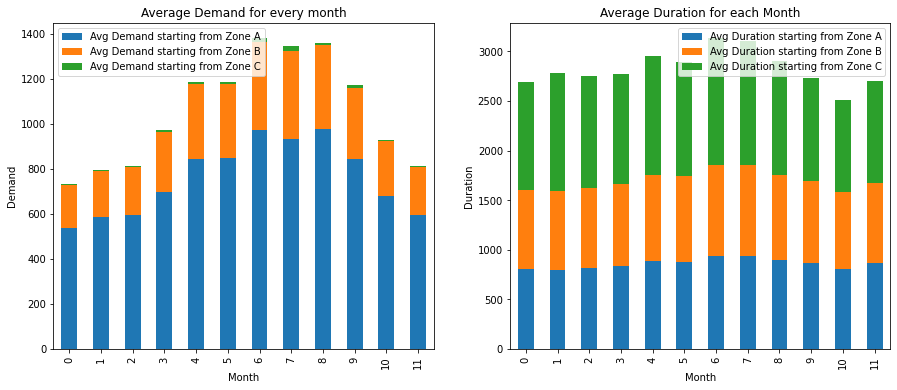

In [ ]:
# plottings ...
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(15, 6)

hiresAg_month_start[["Avg Demand starting from Zone A", "Avg Demand starting from Zone B", "Avg Demand starting from Zone C"]].plot(kind = "bar", stacked = True, ax = ax1)
ax1.set(xlabel = "Month", ylabel = "Demand", title = "Average Demand for every month")

# Average Duration by Hour of the day for reach month
hiresAg_month_start[["Avg Duration starting from Zone A", "Avg Duration starting from Zone B", "Avg Duration starting from Zone C"]].plot(kind = "bar", stacked = True, ax = ax2)
ax2.set(xlabel = "Month", ylabel = "Duration", title = "Average Duration for each Month")

In [ ]:
# ending to Zone A...
mini_hires = hires.loc[hires["end_station_zone"] == 1]
hiresAg = mini_hires[["month",	"day", "week_day", "hour", "duration"]] \
.groupby(["month",	"day", "week_day",	"hour"], as_index = False).agg(["count", "mean"]).reset_index()

# again sorting
hiresAg = hiresAg.sort_values(by = ["month",	"day"], ascending = True)

# pretty print
mylist = list(map(int, hiresAg["duration"].values[:, 0]))
hiresAg["counts"] = mylist

mylist = list(hiresAg["duration"].values[:, 1])
hiresAg["avg_duration"] = mylist; del hiresAg["duration"]
hiresAg = hiresAg.reset_index()

# create the new df
temp_hiresAg_month = pd.DataFrame(hiresAg.groupby("month")["counts"].mean()).reset_index()
temp_hiresAg_month2 = pd.DataFrame(hiresAg.groupby("month")["avg_duration"].mean()).reset_index()
hiresAg_month_end = temp_hiresAg_month
hiresAg_month_end.columns = ["month", "Avg Demand ending to Zone A"]
hiresAg_month_end["Avg Duration ending to Zone A"] = temp_hiresAg_month2["avg_duration"]

# ending to Zone B...
mini_hires = hires.loc[hires["end_station_zone"] == 2]
hiresAg = mini_hires[["month",	"day", "week_day", "hour", "duration"]] \
.groupby(["month",	"day", "week_day",	"hour"], as_index = False).agg(["count", "mean"]).reset_index()

# again sorting
hiresAg = hiresAg.sort_values(by = ["month",	"day"], ascending = True)

# pretty print
mylist = list(map(int, hiresAg["duration"].values[:, 0]))
hiresAg["counts"] = mylist

mylist = list(hiresAg["duration"].values[:, 1])
hiresAg["avg_duration"] = mylist; del hiresAg["duration"]
hiresAg = hiresAg.reset_index()

temp_hiresAg_month = pd.DataFrame(hiresAg.groupby("month")["counts"].mean()).reset_index()
temp_hiresAg_month2 = pd.DataFrame(hiresAg.groupby("month")["avg_duration"].mean()).reset_index()
hiresAg_month_end["Avg Demand ending to Zone B"] = temp_hiresAg_month["counts"]
hiresAg_month_end["Avg Duration ending to Zone B"] = temp_hiresAg_month2["avg_duration"]

# ending to Zone C...
mini_hires = hires.loc[hires["end_station_zone"] == 3]
hiresAg = mini_hires[["month",	"day", "week_day", "hour", "duration"]] \
.groupby(["month",	"day", "week_day",	"hour"], as_index = False).agg(["count", "mean"]).reset_index()

# again sorting
hiresAg = hiresAg.sort_values(by = ["month",	"day"], ascending = True)

# pretty print
mylist = list(map(int, hiresAg["duration"].values[:, 0]))
hiresAg["counts"] = mylist

mylist = list(hiresAg["duration"].values[:, 1])
hiresAg["avg_duration"] = mylist; del hiresAg["duration"]
hiresAg = hiresAg.reset_index()

temp_hiresAg_month = pd.DataFrame(hiresAg.groupby("month")["counts"].mean()).reset_index()
temp_hiresAg_month2 = pd.DataFrame(hiresAg.groupby("month")["avg_duration"].mean()).reset_index()
hiresAg_month_end["Avg Demand ending to Zone C"] = temp_hiresAg_month["counts"]
hiresAg_month_end["Avg Duration ending to Zone C"] = temp_hiresAg_month2["avg_duration"]

[Text(0, 0.5, 'Duration'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Average Duration for each Month')]

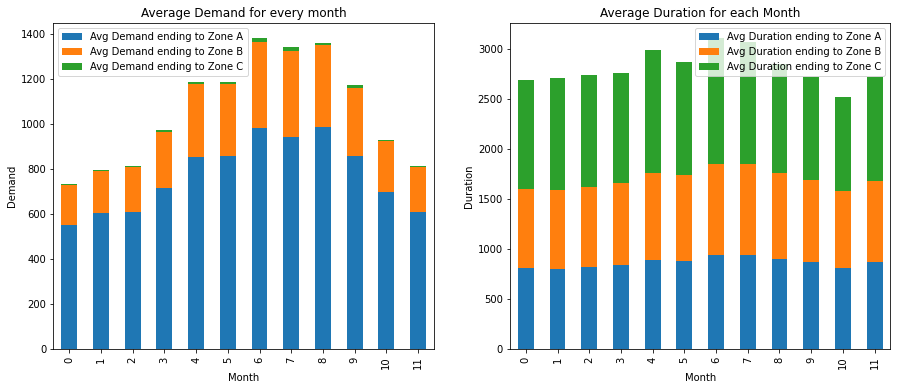

In [ ]:
# plottings ...
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(15, 6)

hiresAg_month_end[["Avg Demand ending to Zone A", "Avg Demand ending to Zone B", "Avg Demand ending to Zone C"]].plot(kind = "bar", stacked = True, ax = ax1)
ax1.set(xlabel = "Month", ylabel = "Demand", title = "Average Demand for every month")

# Average Duration by Hour of the day for reach month
hiresAg_month_end[["Avg Duration ending to Zone A", "Avg Duration ending to Zone B", "Avg Duration ending to Zone C"]].plot(kind = "bar", stacked = True, ax = ax2)
ax2.set(xlabel = "Month", ylabel = "Duration", title = "Average Duration for each Month")

In [ ]:
# starting very close to a subway station
mini_hires = hires.loc[hires["start_station_distance"] == "Very Close"]
hiresAg = mini_hires[["month",	"day", "start_day", "week_day", "hour", "duration"]] \
.groupby(["month",	"day", "start_day", "week_day",	"hour"], as_index = False).agg(["count", "mean"]).reset_index()

# again sorting
hiresAg = hiresAg.sort_values(by = ["month",	"day"], ascending = True)

# pretty print
mylist = list(map(int, hiresAg["duration"].values[:, 0]))
hiresAg["counts"] = mylist

mylist = list(hiresAg["duration"].values[:, 1])
hiresAg["avg_duration"] = mylist; del hiresAg["duration"]
hiresAg = hiresAg.reset_index()

# create the new df
temp_hiresAg_month = pd.DataFrame(hiresAg.groupby("month")["counts"].mean()).reset_index()
temp_hiresAg_month2 = pd.DataFrame(hiresAg.groupby("month")["avg_duration"].mean()).reset_index()
hiresAg_month_start = temp_hiresAg_month
hiresAg_month_start.columns = ["month", "Avg Demand starting very close from a subway station"]
hiresAg_month_start["Avg Duration starting very close from a subway station"] = temp_hiresAg_month2["avg_duration"]

# starting from Zone B...
mini_hires = hires.loc[hires["start_station_distance"] == "Close"]
hiresAg = mini_hires[["month",	"day", "start_day", "week_day", "hour", "duration"]] \
.groupby(["month",	"day", "start_day", "week_day",	"hour"], as_index = False).agg(["count", "mean"]).reset_index()

# again sorting
hiresAg = hiresAg.sort_values(by = ["month",	"day"], ascending = True)

# pretty print
mylist = list(map(int, hiresAg["duration"].values[:, 0]))
hiresAg["counts"] = mylist

mylist = list(hiresAg["duration"].values[:, 1])
hiresAg["avg_duration"] = mylist; del hiresAg["duration"]
hiresAg = hiresAg.reset_index()

temp_hiresAg_month = pd.DataFrame(hiresAg.groupby("month")["counts"].mean()).reset_index()
temp_hiresAg_month2 = pd.DataFrame(hiresAg.groupby("month")["avg_duration"].mean()).reset_index()
hiresAg_month_start["Avg Demand starting close from a subway station"] = temp_hiresAg_month["counts"]
hiresAg_month_start["Avg Duration starting close from a subway station"] = temp_hiresAg_month2["avg_duration"]

# starting from Zone C...
mini_hires = hires.loc[hires["start_station_distance"] == "Long"]
hiresAg = mini_hires[["month",	"day", "start_day", "week_day", "hour", "duration"]] \
.groupby(["month",	"day", "start_day", "week_day",	"hour"], as_index = False).agg(["count", "mean"]).reset_index()

# again sorting
hiresAg = hiresAg.sort_values(by = ["month",	"day"], ascending = True)

# pretty print
mylist = list(map(int, hiresAg["duration"].values[:, 0]))
hiresAg["counts"] = mylist

mylist = list(hiresAg["duration"].values[:, 1])
hiresAg["avg_duration"] = mylist; del hiresAg["duration"]
hiresAg = hiresAg.reset_index()

temp_hiresAg_month = pd.DataFrame(hiresAg.groupby("month")["counts"].mean()).reset_index()
temp_hiresAg_month2 = pd.DataFrame(hiresAg.groupby("month")["avg_duration"].mean()).reset_index()
hiresAg_month_start["Avg Demand starting long from a subway station"] = temp_hiresAg_month["counts"]
hiresAg_month_start["Avg Duration starting long from a subway station"] = temp_hiresAg_month2["avg_duration"]

[Text(0, 0.5, 'Duration'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Average Duration for each Month')]

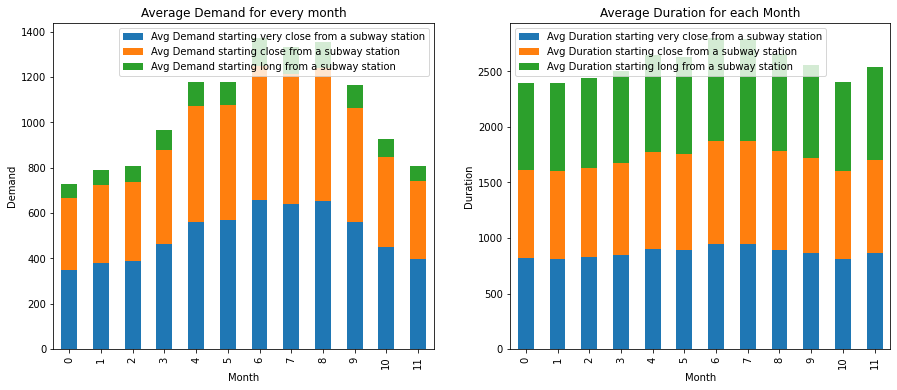

In [ ]:
# plottings ...
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(15, 6)

hiresAg_month_start[["Avg Demand starting very close from a subway station", "Avg Demand starting close from a subway station", "Avg Demand starting long from a subway station"]]\
        .plot(kind = "bar", stacked = True, ax = ax1)
ax1.set(xlabel = "Month", ylabel = "Demand", title = "Average Demand for every month")

# Average Duration by Hour of the day for reach month
hiresAg_month_start[["Avg Duration starting very close from a subway station", "Avg Duration starting close from a subway station", "Avg Duration starting long from a subway station"]] \
.plot(kind = "bar", stacked = True, ax = ax2)
ax2.set(xlabel = "Month", ylabel = "Duration", title = "Average Duration for each Month")

In [ ]:
# ending to Zone A...
mini_hires = hires.loc[hires["end_station_distance"] == "Very Close"]
hiresAg = mini_hires[["month",	"day", "week_day", "hour", "duration"]] \
.groupby(["month",	"day", "week_day",	"hour"], as_index = False).agg(["count", "mean"]).reset_index()

# again sorting
hiresAg = hiresAg.sort_values(by = ["month",	"day"], ascending = True)

# pretty print
mylist = list(map(int, hiresAg["duration"].values[:, 0]))
hiresAg["counts"] = mylist

mylist = list(hiresAg["duration"].values[:, 1])
hiresAg["avg_duration"] = mylist; del hiresAg["duration"]
hiresAg = hiresAg.reset_index()

# create the new df
temp_hiresAg_month = pd.DataFrame(hiresAg.groupby("month")["counts"].mean()).reset_index()
temp_hiresAg_month2 = pd.DataFrame(hiresAg.groupby("month")["avg_duration"].mean()).reset_index()
hiresAg_month_end = temp_hiresAg_month
hiresAg_month_end.columns = ["month", "Avg Demand ending very close to a subway station"]
hiresAg_month_end["Avg Duration ending very close to a subway station"] = temp_hiresAg_month2["avg_duration"]

# ending to Zone B...
mini_hires = hires.loc[hires["end_station_distance"] == "Close"]
hiresAg = mini_hires[["month",	"day", "week_day", "hour", "duration"]] \
.groupby(["month",	"day", "week_day",	"hour"], as_index = False).agg(["count", "mean"]).reset_index()

# again sorting
hiresAg = hiresAg.sort_values(by = ["month",	"day"], ascending = True)

# pretty print
mylist = list(map(int, hiresAg["duration"].values[:, 0]))
hiresAg["counts"] = mylist

mylist = list(hiresAg["duration"].values[:, 1])
hiresAg["avg_duration"] = mylist; del hiresAg["duration"]
hiresAg = hiresAg.reset_index()

temp_hiresAg_month = pd.DataFrame(hiresAg.groupby("month")["counts"].mean()).reset_index()
temp_hiresAg_month2 = pd.DataFrame(hiresAg.groupby("month")["avg_duration"].mean()).reset_index()
hiresAg_month_end["Avg Demand ending close to a subway station"] = temp_hiresAg_month["counts"]
hiresAg_month_end["Avg Duration ending close to a subway station"] = temp_hiresAg_month2["avg_duration"]

# ending to Zone C...
mini_hires = hires.loc[hires["end_station_distance"] == "Long"]
hiresAg = mini_hires[["month",	"day", "week_day", "hour", "duration"]] \
.groupby(["month",	"day", "week_day",	"hour"], as_index = False).agg(["count", "mean"]).reset_index()

# again sorting
hiresAg = hiresAg.sort_values(by = ["month",	"day"], ascending = True)

# pretty print
mylist = list(map(int, hiresAg["duration"].values[:, 0]))
hiresAg["counts"] = mylist

mylist = list(hiresAg["duration"].values[:, 1])
hiresAg["avg_duration"] = mylist; del hiresAg["duration"]
hiresAg = hiresAg.reset_index()

temp_hiresAg_month = pd.DataFrame(hiresAg.groupby("month")["counts"].mean()).reset_index()
temp_hiresAg_month2 = pd.DataFrame(hiresAg.groupby("month")["avg_duration"].mean()).reset_index()
hiresAg_month_end["Avg Demand ending long to a subway station"] = temp_hiresAg_month["counts"]
hiresAg_month_end["Avg Duration ending long to a subway station"] = temp_hiresAg_month2["avg_duration"]

[Text(0, 0.5, 'Duration'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Average Duration for each Month')]

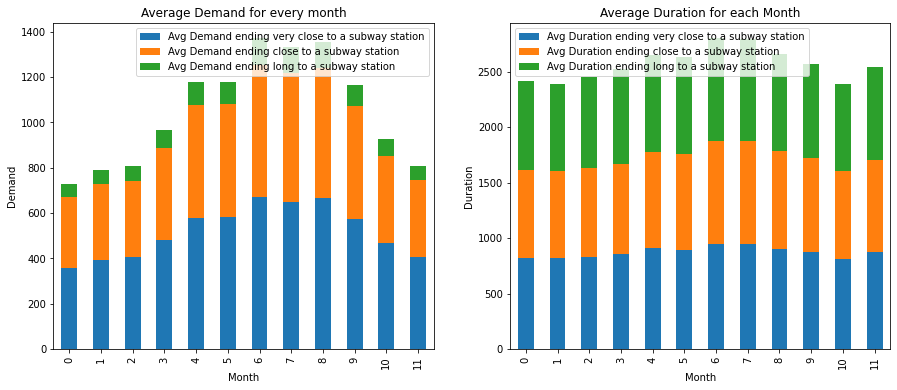

In [ ]:
# plottings ...
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(15, 6)

hiresAg_month_end[["Avg Demand ending very close to a subway station", "Avg Demand ending close to a subway station", "Avg Demand ending long to a subway station"]].plot(kind = "bar", stacked = True, ax = ax1)
ax1.set(xlabel = "Month", ylabel = "Demand", title = "Average Demand for every month")

# Average Duration by Hour of the day for reach month
hiresAg_month_end[["Avg Duration ending very close to a subway station", "Avg Duration ending close to a subway station", "Avg Duration ending long to a subway station"]] \
      .plot(kind = "bar", stacked = True, ax = ax2)
ax2.set(xlabel = "Month", ylabel = "Duration", title = "Average Duration for each Month")

##### What about stations...?

In [ ]:
latitude_dict, longitude_dict = {}, {}
for index, row in mini_stations.iterrows():
    latitude_dict[row["station_id"]] = row["station_latitude"]
    longitude_dict[row["station_id"]] = row["station_longitude"]

# generate combinations between different stations
c = itertools.combinations(station_id_list, 2)

# calculate the avg_distance
dist = 0
count = 0
for stn1, stn2 in c:
        dist += vincenty((latitude_dict[stn1], longitude_dict[stn1]), (latitude_dict[stn2], longitude_dict[stn2])).meters
        count += 1
print("The average distance between two different stations is ", round(dist/count, 3), " m!")

The average distance between two different stations is  5458.545  m!


In [ ]:
# top-10 frequent pairs
k = 10
hires_weekdays = hires[hires["week_day"] <= 4] # week_day =  {0: Mon, 1: Tue, ...., 4: Fri, 5: Sat, 6: Sun}

# Count and sort station pair frequencies
stn_pair_weekdays = hires_weekdays[["start_station_id", "end_station_id"]].groupby(["start_station_id", "end_station_id"]).size().reset_index(name = "counts") \
                    .set_index(["start_station_id", "end_station_id"]).sort_values(by = "counts", ascending = False)
         
top_weekday_pairs = list(stn_pair_weekdays.head(k).index) # Top-10 station pairs (Mon - Fri)

print("Top-10 frequent stations pairs in weekdays are: ", top_weekday_pairs)

Top-10 frequent stations pairs in weekdays are:  [(191, 191), (785, 785), (303, 303), (307, 307), (248, 248), (789, 789), (183, 74), (307, 404), (671, 729), (71, 154)]


In [ ]:
# appropriate installations to import successfully Basemap package
!sudo apt-get install libgeos-3.5.0
!sudo apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

In [ ]:
from mpl_toolkits.basemap import Basemap

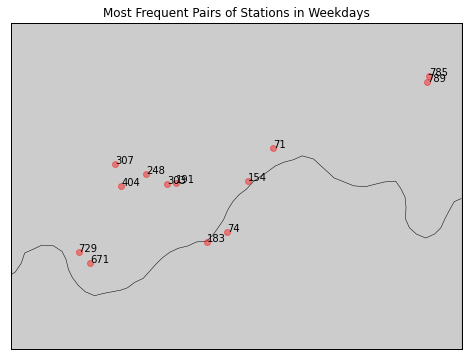

In [ ]:
# plot certain stations, based on the given list
def plot_stations(stns, stations_list = None, title = None, name_flag = True, colour_flag = False):
    if stations_list == None or len(stations_list) == 0:
      return
    stations_list = list(set(stations_list))
    lat = list(stns["station_latitude"])
    lon = list(stns["station_longitude"])
    station_ids = list(mini_stations["station_id"])
    fig, ax = plt.subplots(figsize=(10, 6))
    if title !=  None:
      plt.title(str(title))
    margin = 0.01
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    # create map using BASEMAP
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max - lon_min)/2,
                projection = "lcc",
                resolution = "f",)

    #m.drawcoastlines()
    m.fillcontinents(lake_color = "aqua")
    m.drawmapboundary(fill_color = "aqua")
    m.drawrivers()

    # convert lat and lon to map projection coordinates
    lons, lats = m(lon, lat)
    
    # annotate popular stations
    for i in range(len(lons)):
      if colour_flag == False:
        if station_ids[i] in stations_list:
          ax.scatter(lons[i], lats[i], marker = "o", color = "r", zorder = 3, alpha = 0.4)
          if name_flag == True: plt.text(lons[i], lats[i], station_ids[i])
      else:
        if station_ids[i] in stations_list:
          ax.scatter(lons[i], lats[i], marker = "o", color = "g", zorder = 3, alpha = 0.4)
          if name_flag == True: plt.text(lons[i], lats[i], station_ids[i])

plot_stations(mini_stations, [191, 785, 303, 307, 248, 789, 183, 74, 404, 671, 729, 71, 154], "Most Frequent Pairs of Stations in Weekdays")

In [ ]:
hires_weekends = hires[hires["week_day"] > 4]

stn_pair_weekends = hires_weekends[["start_station_id", "end_station_id"]].groupby(["start_station_id", "end_station_id"]).size().reset_index(name = "counts") \
                    .set_index(["start_station_id", "end_station_id"]).sort_values(by = "counts", ascending = False)

top_weekend_pairs = list(stn_pair_weekends.head(k).index)

print("Top-10 frequent stations pairs in weekends are: ", top_weekend_pairs)

Top-10 frequent stations pairs in weekends are:  [(191, 191), (785, 785), (307, 307), (303, 303), (789, 789), (248, 248), (786, 785), (307, 191), (191, 248), (307, 303)]


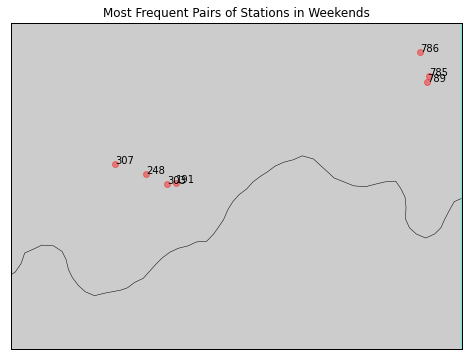

In [ ]:
plot_stations(mini_stations, [191, 785, 303, 307, 248, 789, 248, 786, 785, 191], "Most Frequent Pairs of Stations in Weekends")

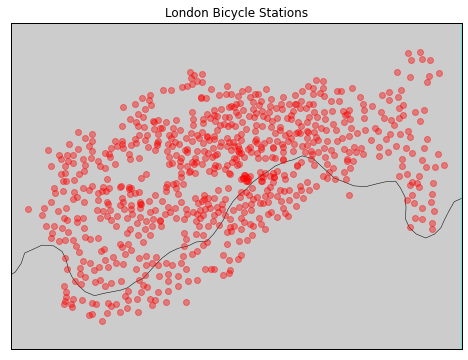

In [ ]:
# Stations Plotting
fig, ax = plt.subplots(figsize=(10,6))

# determine range to print based on min, max lat and lon of the data
lat = list(mini_stations["station_latitude"])
lon = list(mini_stations["station_longitude"])
text = list(mini_stations["station_id"])
margin = 0.01
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lon_max - lon_min)/2,
            projection='lcc',
            resolution = 'f',)

m.shadedrelief()

try:
    m.drawcoastlines()
except:
    pass

#m.drawcountries(color='gray')
#m.drawstates(color='gray')

m.fillcontinents(lake_color = "aqua")
m.drawmapboundary(fill_color = "aqua")
m.drawrivers()


# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)

# plot points as red dots
ax.scatter(lons, lats, marker = "o", color = "r", zorder = 3, alpha = 0.4)
plt.title("London Bicycle Stations")
plt.show()

In [ ]:
# sorting avg_outflow per station
average_inflow = dat[["station_id", "in_flow_count"]].groupby(["station_id"]).mean().sort_values(by = "in_flow_count", ascending = False)

# sorting avg_inflow per station
average_outflow = dat[["station_id", "out_flow_count"]].groupby(["station_id"]).mean().sort_values(by = "out_flow_count", ascending = False)
            
top_inflow_stations = list(average_inflow.head(10).index)
top_outflow_stations = list(average_outflow.head(10).index)

print("Top-10 stations with highest inflow are: ", top_inflow_stations)
print("Top-10 stations with highest outflow are: ", top_outflow_stations)

Top-10 stations with highest inflow are:  [14, 154, 194, 374, 217, 191, 66, 251, 71, 55]
Top-10 stations with highest outflow are:  [14, 154, 374, 191, 217, 194, 307, 55, 303, 251]


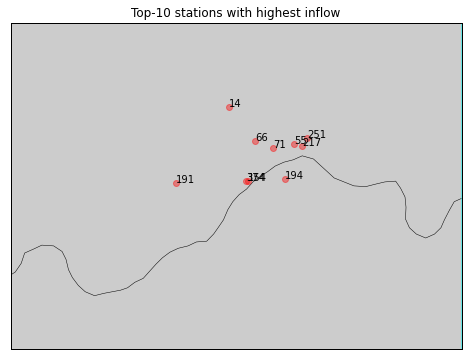

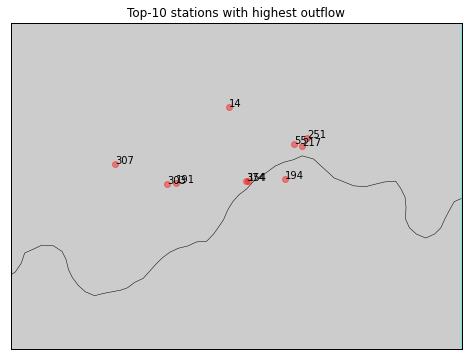

In [ ]:
plot_stations(mini_stations, top_inflow_stations, "Top-10 stations with highest inflow")
plot_stations(mini_stations, top_outflow_stations, "Top-10 stations with highest outflow")

In [ ]:
 # total flows per time for each station
dat["flow_count"] = dat["in_flow_count"] + dat["out_flow_count"]

# sorting by avg_flow
avg_flow = dat[["station_id", "flow_count"]].groupby(["station_id"]).mean().sort_values(by = "flow_count", ascending = False)

# keep only the top-10 popular stations
avg_flow = avg_flow.reset_index().head(10)
avg_flow = pd.merge(left = avg_flow, right = stations, left_on = "station_id", right_on = "id")
avg_flow = avg_flow[["name", "id", "flow_count"]]
avg_flow.columns = ["station_name", "station_id", "avg_flow_count"]
avg_flow

,station_name,station_id,avg_flow_count
0,"Belgrove Street , King's Cross",14,10.676173
1,"Waterloo Station 3, Waterloo",154,8.907218
2,"Waterloo Station 1, Waterloo",374,6.277095
3,"Hop Exchange, The Borough",194,5.984119
4,"Hyde Park Corner, Hyde Park",191,5.599898
5,"Wormwood Street, Liverpool Street",217,5.474613
6,"Finsbury Circus, Liverpool Street",55,5.011157
7,"Brushfield Street, Liverpool Street",251,4.985087
8,"Newgate Street , St. Paul's",71,4.849442
9,"Albert Gate, Hyde Park",303,4.840733


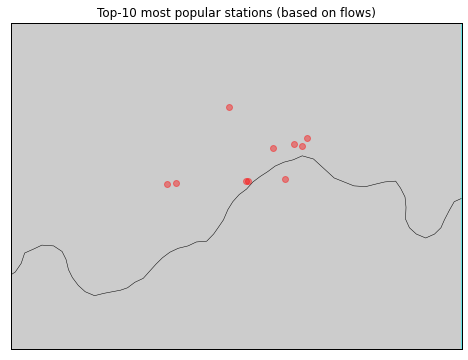

In [ ]:
plot_stations(stns = mini_stations, stations_list = avg_flow["station_id"].tolist(),
              title = "Top-10 most popular stations (based on flows)", name_flag = False)

##### PageRank algorithm

In [ ]:
# appropriate form of data before applying PageRank Algorithm
data_for_rank = hires
data_for_rank["count"] = 1
data_for_rank = data_for_rank[["start_station_id", "end_station_id", "count"]].groupby(["start_station_id", "end_station_id"]).sum().reset_index()

network = nx.from_pandas_edgelist(data_for_rank, "start_station_id", "end_station_id", edge_attr = ["count"])
pagerank = pd.DataFrame(list(nx.pagerank(network).items()), columns = ["id", "rank"])

pagerank = pd.merge(left = pagerank, right = mini_stations[["station_id", "station_name"]], left_on = "id", right_on = "station_id")
pagerank.sort_values("rank", axis = 0, inplace=True, ascending = False)
pagerank.reset_index(inplace = True, drop = True)

# top-10 station with highers rankings
pagerank = pagerank[["station_name", "station_id", "rank"]][:10]
pagerank

,station_name,station_id,rank
0,"Whitehall Place, Strand",229,0.001866
1,"Craven Street, Strand",341,0.001852
2,"Somerset House, Strand",564,0.001843
3,"Northumberland Avenue, Strand",354,0.001836
4,"William IV Street, Strand",64,0.001830
5,"Moor Street, Soho",386,0.001823
6,"Green Park Station, Mayfair",541,0.001813
7,"St. James's Square, St. James's",228,0.001809
8,"Newgate Street , St. Paul's",71,0.001805
9,"Soho Square , Soho",109,0.001799


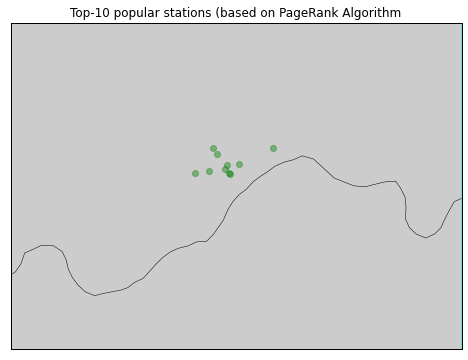

In [ ]:
plot_stations(stns = mini_stations, stations_list = pagerank["station_id"].tolist(),
              title = "Top-10 popular stations (based on PageRank Algorithm", colour_flag = True, name_flag = False)

##### Most Popular Stations for each Season

In [ ]:
# return the period for each hire
def gen_time_group(dt):
  if dt.month >=2 and dt.month <= 4: return "Spring"
  elif dt.month >= 5 and dt.month <= 7: return "Summer"
  elif dt.month >= 8 and dt.month <= 10: return "Autum"
  elif dt.month >= 11: return "Winter"

flow = dat[["station_id", "time", "flow_count"]] 

# create time group
flow["group_time"] = [gen_time_group(dt) for dt in flow["time"]]

flow = flow.groupby(["station_id", "group_time"], as_index = False).agg({"flow_count": "sum"})

# Add latitude/logitude columns
flow["latitude"] = [latitude_dict[x] for x in flow["station_id"]]
flow["longitude"] = [longitude_dict[x] for x in flow["station_id"]]

# print top-5 rows of flow df
flow.head(5)

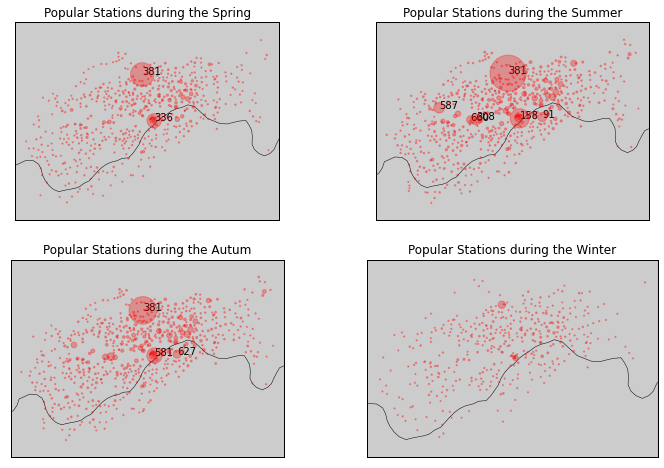

In [ ]:
def plot_stations_flow(stns, noText = False):
    lat = list(stns["latitude"])
    lon = list(stns["longitude"])
    radius = [(2)**(x/5000) for x in stns["flow_count"]]
    margin = 0.01
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    # create map using BASEMAP
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max - lon_min)/2,
                projection = "lcc",
                resolution = "f",)

    #m.drawcoastlines()
    m.fillcontinents(lake_color = "aqua")
    m.drawmapboundary(fill_color = "aqua")
    m.drawrivers()

    # convert lat and lon to map projection coordinates
    lons, lats = m(lon, lat)

    # plot points as red dots
    if noText:
        plt.scatter(lons, lats, marker = "o", color = "r", zorder = 5, alpha = 0.6, s = 1)
        return
    else:
        plt.scatter(lons, lats, marker = "o", color = "r", zorder = 5, alpha = 0.3, s = radius)
    
    # annotate popular stations
    for i in range(len(radius)):
        if radius[i] >= 2**6:
            plt.text(lons[i], lats[i], text[i])


# define a "flow" threashold
pop_flow = flow[flow["flow_count"] > 2500]

# Plottings ...
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(12, 8))

ax = plt.subplot(2, 2, 1)
ax.set_title("Popular Stations during the Spring")
plot_stations_flow(pop_flow[pop_flow["group_time"] == "Spring"])

ax = plt.subplot(2, 2, 2)
ax.set_title("Popular Stations during the Summer")
plot_stations_flow(pop_flow[pop_flow["group_time"] == "Summer"])

ax = plt.subplot(2, 2, 3)
ax.set_title("Popular Stations during the Autum")
plot_stations_flow(pop_flow[pop_flow["group_time"] == "Autum"])

ax = plt.subplot(2, 2, 4)
ax.set_title("Popular Stations during the Winter")
plot_stations_flow(pop_flow[pop_flow["group_time"] == "Winter"])

## Machine Learning (ML)

#### Hourly Demand Prediction

Mounted at /content/drive


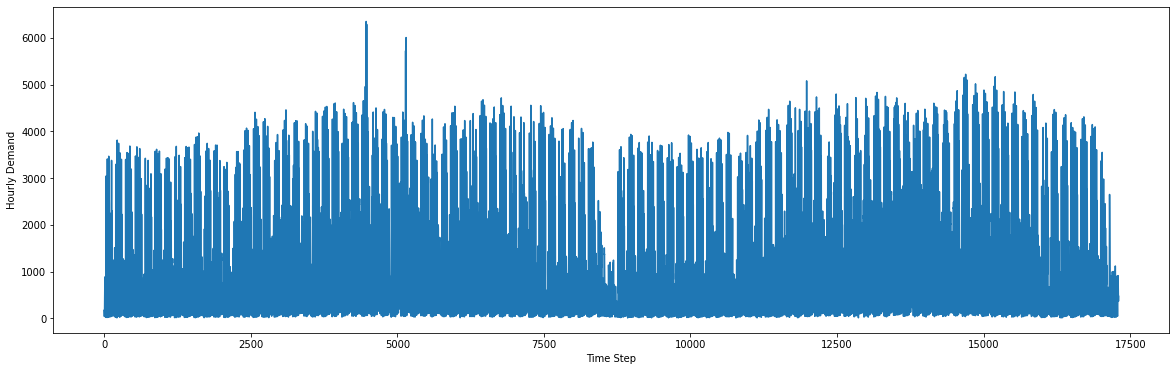

In [ ]:
# read the data (hiresAg for years 2015, 2016)
drive.mount("/content/drive", force_remount = True)
hiresAg_15_16 = pd.read_csv("/content/drive/My Drive/t/hiresAg_15_16.csv")
hiresAg_15_16 = hiresAg_15_16[["temperature",	"pressure",	"humidity",	"wind_speed",	"weather_main",	"season", 
                               "week_day",	"hour",	"weekend_or_holiday", "counts"]]

# plot the hourly demand for 2015 & 2016 to get the big picture
plt.figure(figsize = (20, 6))
plt.xlabel("Time Step")
plt.ylabel("Hourly Demand")
sn.lineplot(x = hiresAg_15_16.index, y = "counts", data = hiresAg_15_16);

In [ ]:
hiresAg_15_16["time_seg"] = None
mask1 = ((hiresAg_15_16.hour >=0) & (hiresAg_15_16.hour <= 6)) | (hiresAg_15_16.hour >= 22)
mask2 = (hiresAg_15_16.hour >= 7) & (hiresAg_15_16.hour <= 13)
mask3 = (hiresAg_15_16.hour >= 14) & (hiresAg_15_16.hour <= 16)
mask4 =  (hiresAg_15_16.hour >= 17) & (hiresAg_15_16.hour <= 21)

hiresAg_15_16.loc[mask1, "time_seg"] = "Night"
hiresAg_15_16.loc[mask2, "time_seg"] = "Morning"
hiresAg_15_16.loc[mask3, "time_seg"] = "Afternoon"
hiresAg_15_16.loc[mask4, "time_seg"] = "Evening"

# categorical features: str type => int64 type
cleanup_nums = {"weather_main": {"Clouds": 1, "Fog": 2, "Mist": 3, "Haze": 4, "Drizzle": 5, "Rain": 6, "Clear": 7, "Thunderstorm": 8, "Snow": 9},
                "time_seg": {"Night": 1, "Morning": 2, "Afternoon": 3, "Evening": 4},
                "season": {"Spring": 1, "Summer": 2, "Autum": 3, "Winter": 4}}
hiresAg_15_16.replace(cleanup_nums, inplace = True)

# reordering of columns
hiresAg_15_16 = hiresAg_15_16[["temperature",	"pressure",	"humidity",	"wind_speed",	"weather_main",	"season", 
                               "time_seg",	"weekend_or_holiday", "counts"]]

# top-5 rows of hiresAg_15_16 df
hiresAg_15_16.head(5)

,temperature,pressure,humidity,wind_speed,weather_main,season,time_seg,weekend_or_holiday,counts
0,2.46,1032.0,97,1.00,1,4,1,1,169
1,2.02,1032.5,96,0.50,1,4,1,1,129
2,1.34,1033.1,96,0.50,1,4,1,1,123
3,0.68,1033.9,97,1.70,1,4,1,1,63
4,0.38,1034.3,97,1.44,1,4,1,1,41


##### Predict demand using a feed-forward NN

In [ ]:
rides = hiresAg_15_16
# Creating dummy variables from non-numerical data
dummy_features = ["weather_main",	"season",	"time_seg",	"weekend_or_holiday"]
for each in dummy_features:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

"""
# Dropping dummy originals and unnecessary variables
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
"""
data = rides.drop(dummy_features, axis=1)
data.head()

,temperature,pressure,humidity,wind_speed,counts,weather_main_1,weather_main_2,weather_main_3,weather_main_4,weather_main_5,weather_main_6,weather_main_7,weather_main_8,weather_main_9,season_1,season_2,season_3,season_4,time_seg_1,time_seg_2,time_seg_3,time_seg_4,weekend_or_holiday_0,weekend_or_holiday_1
0,-1.651702,1.554468,97,-1.389919,169,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
1,-1.729075,1.604785,96,-1.612434,129,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
2,-1.848650,1.665165,96,-1.612434,123,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
3,-1.964709,1.745673,97,-1.078399,63,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
4,-2.017462,1.785926,97,-1.194106,41,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1


In [ ]:
train_size = int(0.9*len(data))
test_size = len(data) - train_size
validation_size = int(0.1*train_size)
train_size -= validation_size
train_set, validation_set, test_set = data.iloc[0:train_size], data.iloc[train_size:train_size + validation_size], data.iloc[train_size + validation_size:len(data)]
print("The size of train set is ", train_size, "!")
print("The size of validation set is ", validation_size, "!")
print("The size of test set is ", test_size, "!")

The size of train set is  14014 !
The size of validation set is  1557 !
The size of test set is  1731 !


In [ ]:
# appropriate scaling of weather (numerical) features
cur_columns = ["temperature", "pressure", "humidity", "wind_speed"]
transformer = StandardScaler()
transformer = transformer.fit(train_set[cur_columns].to_numpy())
train_set.loc[:, cur_columns] = transformer.transform(train_set[cur_columns].to_numpy())
validation_set.loc[:, cur_columns] = transformer.transform(validation_set[cur_columns].to_numpy())
test_set.loc[:, cur_columns] = transformer.transform(test_set[cur_columns].to_numpy())

# appropriate scaling of demant (counts of hires)
cnt_transformer = StandardScaler()
cnt_transformer = cnt_transformer.fit(train_set[["counts"]])
train_set["counts"] = cnt_transformer.transform(train_set[["counts"]])
validation_set["counts"] = cnt_transformer.transform(validation_set[["counts"]])
test_set["counts"] = cnt_transformer.transform(test_set[["counts"]])

# transform data to the form needed before the training-validation & prediction phase
X_train, y_train = train_set.iloc[:, train_set.columns != "counts"], train_set["counts"]
X_validation, y_validation = validation_set.iloc[:, validation_set.columns != "counts"], validation_set["counts"]
X_test, y_test = test_set.iloc[:, test_set.columns != "counts"], test_set["counts"]

In [ ]:
# https://github.com/tamasdinh/bike-sharing-prediction-nn/blob/master/bike_sharing_network_class.py

class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # setting number of nodes in layers
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # initializing weights with normal distribution
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        # activation function for hidden layer (sigmoid)
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))


    def train(self, features, targets):
        '''
        Implements mini-batch training strategy. 
        Arguments:
            - features: 2D array, each row is one data record, each column is a feature
            - targets: 1D array of target values
        '''
        n_records = features.shape[0]
        
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        
        for X, y in zip(features, targets):
            final_outputs, hidden_outputs = self.forward_pass_train(X)
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o)
        
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)


    def forward_pass_train(self, X):
        '''
        Implements forward pass 
        Arguments - X: features batch
        '''

        # signals into hidden layer
        hidden_inputs = np.dot(X, self.weights_input_to_hidden) 
        # signals from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        # signals into final output layer
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        # signals from final output layer (predictions)
        final_outputs = final_inputs
        
        return final_outputs, hidden_outputs


    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        '''
        Implements backpropagation.
        Arguments:
            - final_outputs: output from forward pass
            - y: target (i.e. label) batch
            - delta_weights_i_h: change in weights from input to hidden layers
            - delta_weights_h_o: change in weights from hidden to output layers
        '''

        error = (y - final_outputs)
        output_error_term = error
        hidden_error_term = np.dot(output_error_term, self.weights_hidden_to_output.T) * hidden_outputs * (1 - hidden_outputs)
        
        # Weight steps - incremented due to mini-batch approach
        delta_weights_i_h += hidden_error_term * X[:, None]
        delta_weights_h_o += output_error_term * hidden_outputs[:, None]
        
        return delta_weights_i_h, delta_weights_h_o


    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        '''
        Updates weights on gradient descent step.
        Arguments:
            - delta_weights_i_h: change in weights from input to hidden layers
            - delta_weights_h_o: change in weights from hidden to output layers
            - n_records: number of records (due to mini-batch approach, this variables is used to average gradient steps derived from individual records)
        '''

        self.weights_hidden_to_output += self.lr * delta_weights_h_o.reshape(self.hidden_nodes, 1) / n_records
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records


    def run(self, features):
        '''
        Runs a forward pass through the network (for testing / prediction purposes).
        Arguments:
            - features: 1D array of feature values
        '''
        
        hidden_inputs = np.dot(features, self.weights_input_to_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        final_outputs = final_inputs
        
        return final_outputs

def MSE(y, Y):
    return np.mean((y-Y)**2)

In [ ]:
# Neural Net's Training Phase
# set the appropriate hyparameters
iterations = 5000
learning_rate = 0.6
hidden_nodes = 5
output_nodes = 1
input_nodes = len(X_train.columns)

# define the desired feed-forward NN model
network = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

losses = {"train":[], "validation":[]}
print("Hyperparameters: " + "Epochs: " + str(iterations) + "\t" + "Learning rate: " + str(learning_rate) + \
     "\t" + "Hidden nodes: " + str(hidden_nodes) + "\t")
for ii in range(iterations):
    
    # Going through a random batch of 128 records from the training data set
    batch = np.random.choice(X_train.index, size = 128)
    X, y = X_train.loc[batch].values, y_train.loc[batch]
                             
    network.train(X, y)
    
    train_loss = MSE(network.run(X_train).T, y_train.values)
    val_loss = MSE(network.run(X_validation).T, y_validation.values)
    if ii % 100 == 0:
      print("Training Loss = ", train_loss, ", Validation Loss = ", val_loss)
    
    losses["train"].append(train_loss)
    losses["validation"].append(val_loss)

Hyperparameters: Epochs: 5000	Learning rate: 0.6	Hidden nodes: 5	
Training Loss =  0.9681130834536461 , Validation Loss =  1.5433758785776792
Training Loss =  0.5175752917497404 , Validation Loss =  0.775836941160271
Training Loss =  0.5175039183043953 , Validation Loss =  0.7786307329710963
Training Loss =  0.5077151378923231 , Validation Loss =  0.7557080692198639
Training Loss =  0.5025136042799443 , Validation Loss =  0.7464055858524312
Training Loss =  0.5169255196440936 , Validation Loss =  0.7919046003983555
Training Loss =  0.4914095644385344 , Validation Loss =  0.7286849424831495
Training Loss =  0.48107916314694854 , Validation Loss =  0.7153159149010538
Training Loss =  0.4721156169340743 , Validation Loss =  0.6887359194064966
Training Loss =  0.4570489278173192 , Validation Loss =  0.6760143779231459
Training Loss =  0.43979260823997185 , Validation Loss =  0.6484537978945731
Training Loss =  0.4274915447925234 , Validation Loss =  0.6276467412618086
Training Loss =  0.41

(0.0, 1.5)

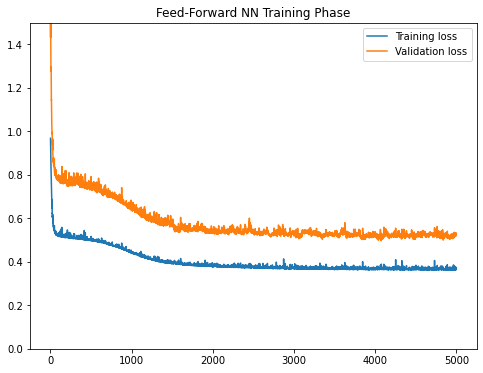

In [ ]:
plt.figure(figsize = (8, 6))
plt.title("Feed-Forward NN Training Phase")
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim([0, 1.5])

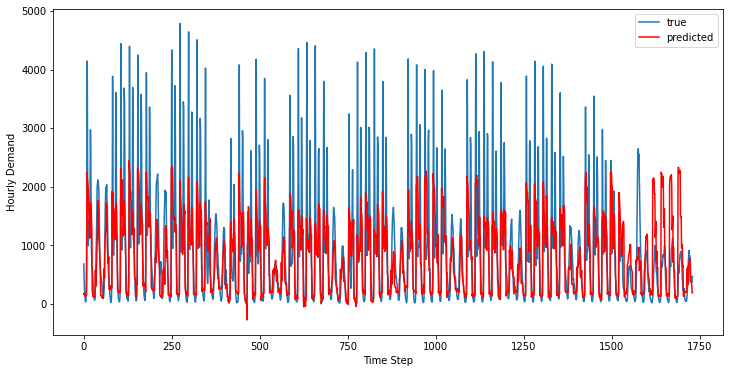

In [ ]:
# make prediction on th test set
y_pred = network.run(X_test)

# apply inverse transformation at the independent value (hourly hires counts/demand)
y_train_inv = cnt_transformer.inverse_transform(np.array(y_train).reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(np.array(y_test).reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

# plotting
plt.figure(figsize = (12, 6))
plt.plot(y_test_inv.flatten(), label = "true")
plt.plot(y_pred_inv.flatten(), "r", label = "predicted")
plt.ylabel("Hourly Demand")
plt.xlabel("Time Step")
plt.legend()
plt.show();

##### Hourly Demand Prediction using Random Forest

In [ ]:
# Creating dummy variables from non-numerical data
rides = hiresAg_15_16
dummy_features = ["weather_main",	"season",	"time_seg",	"weekend_or_holiday"]
for each in dummy_features:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

data = rides.drop(dummy_features, axis=1)
data.head()

,temperature,pressure,humidity,wind_speed,counts,weather_main_1,weather_main_2,weather_main_3,weather_main_4,weather_main_5,weather_main_6,weather_main_7,weather_main_8,weather_main_9,season_1,season_2,season_3,season_4,time_seg_1,time_seg_2,time_seg_3,time_seg_4,weekend_or_holiday_0,weekend_or_holiday_1
0,2.46,1032.0,97,1.00,169,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
1,2.02,1032.5,96,0.50,129,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
2,1.34,1033.1,96,0.50,123,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
3,0.68,1033.9,97,1.70,63,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
4,0.38,1034.3,97,1.44,41,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1


In [ ]:
# create Train & Test Data
X, y = data.iloc[:, data.columns != "counts"], data["counts"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# scaling
cur_columns = ["temperature", "pressure", "humidity", "wind_speed"]
transformer = StandardScaler()
transformer = transformer.fit(X_train[cur_columns].to_numpy())
X_train.loc[:, cur_columns] = transformer.transform(X_train[cur_columns].to_numpy())
X_test.loc[:, cur_columns] = transformer.transform(X_test[cur_columns].to_numpy())

# appropriate scaling of demant (counts of hires)
cnt_transformer = StandardScaler()
cnt_transformer = cnt_transformer.fit(pd.DataFrame(y_train))
y_train = cnt_transformer.transform(pd.DataFrame(y_train))
y_test = cnt_transformer.transform(pd.DataFrame(y_test))

In [ ]:
# pretty print
table = PrettyTable()
table.field_names = ["Model", "RMSE", "MAE", "R² score"]

# define model
model = RandomForestRegressor(n_estimators = 100, random_state = 42)

# fit the above model
model.fit(X_train, y_train)

# make prediction on Test Set
y_pred = model.predict(X_test)

# take the appropriate metrics
RMSE = mean_squared_error(y_test, y_pred, squared = False)
MAE = mean_absolute_error(y_test, y_pred)
R2 = model.score(X_test, y_test)    

# print pretty table
table.add_row([type(model).__name__, format(RMSE, ".2f"), format(MAE, ".2f"), format(R2, ".2f")])
print(table)

+-----------------------+------+------+----------+
|         Model         | RMSE | MAE  | R² score |
+-----------------------+------+------+----------+
| RandomForestRegressor | 0.55 | 0.36 |   0.68   |
+-----------------------+------+------+----------+


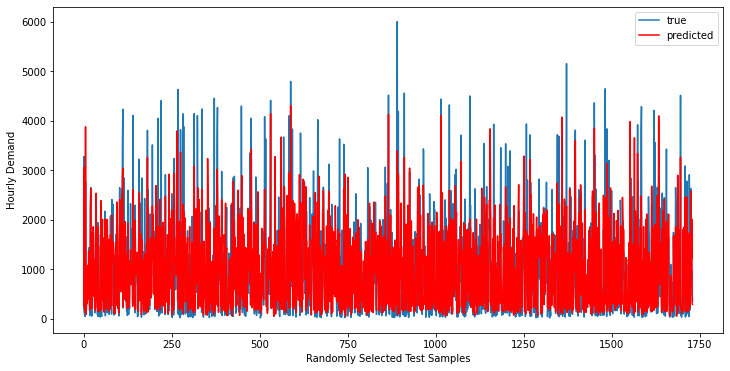

In [ ]:
# apply inverse transformation at the independent value (hourly hires counts/demand)
y_train_inv = cnt_transformer.inverse_transform(np.array(y_train).reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(np.array(y_test).reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

# plotting
plt.figure(figsize = (12, 6))
plt.plot(y_test_inv.flatten(), label = "true")
plt.plot(y_pred_inv.flatten(), "r", label = "predicted")
plt.ylabel("Hourly Demand")
plt.xlabel("Randomly Selected Test Samples")
plt.legend()
plt.show();

In [ ]:
# feature importance
features = data.columns.tolist()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)
indices = np.argsort(importances)[::-1][:10]

# print the results
print("Top-10 Ranking Features:")
for f in range(10):
    print("%d. feature: %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Top-10 Ranking Features:
1. feature: season_4 (0.376391)
2. feature: temperature (0.168551)
3. feature: humidity (0.133231)
4. feature: pressure (0.102065)
5. feature: wind_speed (0.058052)
6. feature: time_seg_4 (0.035207)
7. feature: time_seg_3 (0.024310)
8. feature: weekend_or_holiday_0 (0.024127)
9. feature: time_seg_2 (0.017991)
10. feature: time_seg_1 (0.010521)


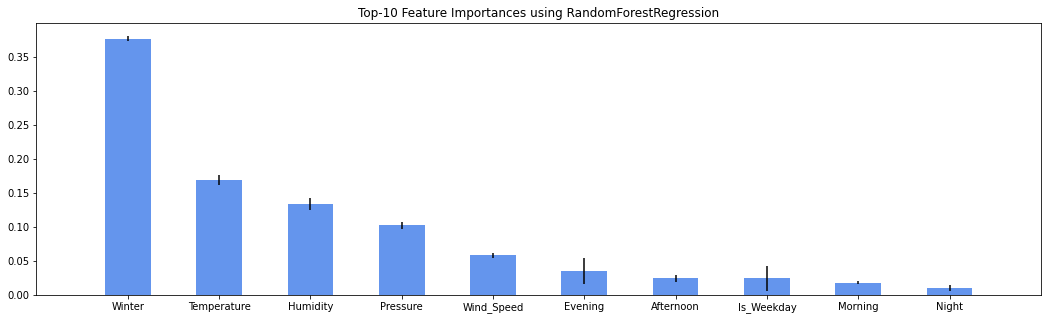

In [ ]:
# relative plot
plt.figure(figsize = (18,5))
plt.title("Top-10 Feature Importances using RandomForestRegression")
plt.bar(range(10), importances[indices], color = "cornflowerblue", yerr = std[indices], align = "center", width = 0.5)
new_labels = ["Winter", "Temperature", "Humidity", "Pressure", "Wind_Speed", "Evening", "Afternoon", "Is_Weekday", "Morning", "Night"]
plt.xticks(range(10), new_labels)
plt.xlim([-1, 10])
plt.show()

##### Hourly Demand Prediction using Deep Learning Methods (GRU, LSTM, BiLSTM)

In [ ]:
# create train & test sets
train_size = int(0.9*len(hiresAg_15_16))
test_size = len(hiresAg_15_16) - train_size
train_set, test_set = hiresAg_15_16.iloc[0:train_size], hiresAg_15_16.iloc[train_size:len(hiresAg_15_16)]
print("The size of train set is ", train_size, "!")
print("The size of test set is ", test_size, "!")

The size of train set is  15571 !
The size of test set is  1731 !


In [ ]:
# preprocessing phase of the demand prediction using LSTM
# scale appropriately the following (weather) features

cur_columns = ["temperature", "pressure", "humidity", "wind_speed"]
transformer = StandardScaler()
transformer = transformer.fit(train_set[cur_columns].to_numpy())
train_set.loc[:, cur_columns] = transformer.transform(train_set[cur_columns].to_numpy())
test_set.loc[:, cur_columns] = transformer.transform(test_set[cur_columns].to_numpy())

# appropriate scaling of demant (counts of hires)
cnt_transformer = StandardScaler()
cnt_transformer = cnt_transformer.fit(train_set[["counts"]])
train_set["counts"] = cnt_transformer.transform(train_set[["counts"]])
test_set["counts"] = cnt_transformer.transform(test_set[["counts"]])

In [ ]:
# build in an appropriate form the dataset, before it's feeded to LSTM input
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps), :].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# transform data to the appropriate form for the training-validation & prediction phase
time_steps = 30
X_train, y_train = create_dataset(train_set, train_set.counts, time_steps)
X_test, y_test = create_dataset(test_set, test_set.counts, time_steps)

###### GRU

In [ ]:
model1 = Sequential()
model1.add(GRU(units = 32, input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(Dropout(rate = 0.2))
model1.add(Dense(units = 1))
model1.compile(loss = "mse", optimizer = "adam")

early_stopping = EarlyStopping(monitor = "val_loss", mode = "min", patience = 10)

In [ ]:
# train our model model in 50 epochs, using early stopping with validation set the 10% of train set
history1 = model1.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_split = 0.1, callbacks = [early_stopping], shuffle = False)

Epoch 1/50
438/438 [==============================] - 6s 13ms/step - loss: 0.4546 - val_loss: 0.2934
Epoch 2/50
438/438 [==============================] - 6s 13ms/step - loss: 0.2090 - val_loss: 0.1418
Epoch 3/50
438/438 [==============================] - 6s 13ms/step - loss: 0.1327 - val_loss: 0.1019
Epoch 4/50
438/438 [==============================] - 6s 13ms/step - loss: 0.1054 - val_loss: 0.0863
Epoch 5/50
438/438 [==============================] - 6s 13ms/step - loss: 0.0891 - val_loss: 0.0648
Epoch 6/50
438/438 [==============================] - 6s 13ms/step - loss: 0.0693 - val_loss: 0.0454
Epoch 7/50
438/438 [==============================] - 6s 13ms/step - loss: 0.0548 - val_loss: 0.0368
Epoch 8/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0503 - val_loss: 0.0371
Epoch 9/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0464 - val_loss: 0.0333
Epoch 10/50
438/438 [==============================] - 6s 13ms/step - loss: 0.0447 - val_lo

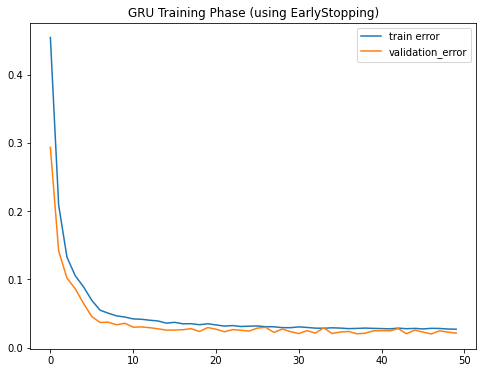

In [ ]:
plt.figure(figsize = (8, 6))
plt.title("GRU Training Phase (using EarlyStopping)")
plt.plot(history1.history["loss"], label = "train error")
plt.plot(history1.history["val_loss"], label = "validation error")
plt.legend();

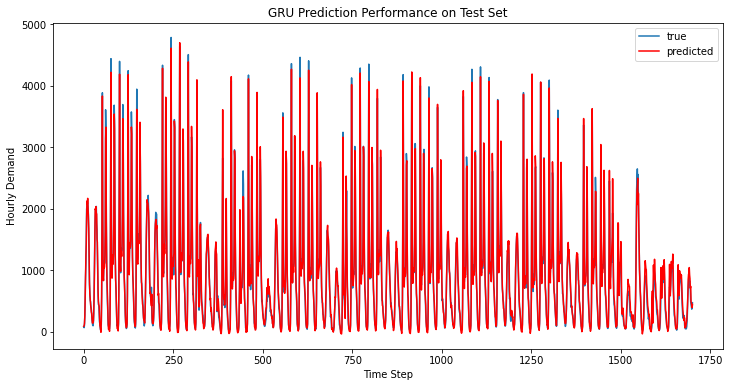

In [ ]:
# make prediction on th test set
y_pred_1 = model1.predict(X_test)

# apply inverse transformation at the independent value (hourly hires counts/demand)
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv_1 = cnt_transformer.inverse_transform(y_pred_1)

# plotting
plt.figure(figsize = (12, 6))
plt.plot(y_test_inv.flatten(), label = "true")
plt.plot(y_pred_inv_1.flatten(), "r", label = "predicted")
plt.ylabel("Hourly Demand")
plt.xlabel("Time Step")
plt.title("GRU Prediction Performance on Test Set")
plt.legend()
plt.show()

In [ ]:
# evaluate GRU's performance & PrettyPrint
table = PrettyTable()
table.field_names = ["Model", "RMSE", "MEA", "R² score"]

# regression evalution metrics
RMSE = mean_squared_error(y_test, y_pred_1, squared = False)
MAE = mean_absolute_error(y_test, y_pred_1)
R2 = r2_score(y_test, y_pred_1)    

# print pretty table
table.add_row(["GRU", format(RMSE, ".4f"), format(MAE, ".4f"), format(R2, ".4f")])
print(table)

+-------+--------+--------+----------+
| Model |  RMSE  |  MEA   | R² score |
+-------+--------+--------+----------+
|  GRU  | 0.1190 | 0.0797 |  0.9822  |
+-------+--------+--------+----------+


###### LSTM

In [ ]:
# 2nd model
model2 = Sequential()
model2.add(LSTM(units = 32, input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dropout(rate = 0.2))
model2.add(Dense(units = 1))
model2.compile(loss = "mse", optimizer = "adam")

early_stopping = EarlyStopping(monitor = "val_loss", mode = "min", patience = 10)

In [ ]:
# train our model model in 50 epochs, using early stopping with validation set the 10% of train set
history2 = model2.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_split = 0.1, callbacks = [early_stopping], shuffle = False)

Epoch 1/50
438/438 [==============================] - 6s 13ms/step - loss: 0.4386 - val_loss: 0.2913
Epoch 2/50
438/438 [==============================] - 5s 12ms/step - loss: 0.1934 - val_loss: 0.1401
Epoch 3/50
438/438 [==============================] - 5s 12ms/step - loss: 0.1178 - val_loss: 0.1030
Epoch 4/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0944 - val_loss: 0.0744
Epoch 5/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0772 - val_loss: 0.0618
Epoch 6/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0664 - val_loss: 0.0468
Epoch 7/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0582 - val_loss: 0.0435
Epoch 8/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0522 - val_loss: 0.0379
Epoch 9/50
438/438 [==============================] - 5s 11ms/step - loss: 0.0486 - val_loss: 0.0350
Epoch 10/50
438/438 [==============================] - 5s 12ms/step - loss: 0.0450 - val_lo

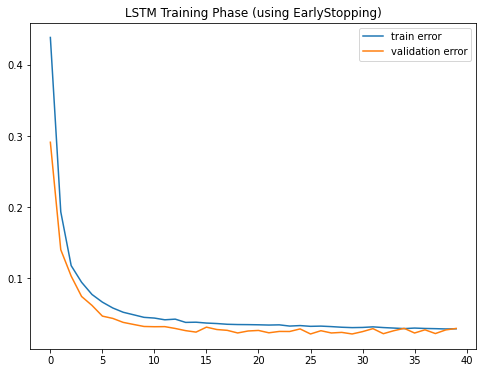

In [ ]:
plt.figure(figsize = (8, 6))
plt.title("LSTM Training Phase (using EarlyStopping)")
plt.plot(history2.history["loss"], label = "train error")
plt.plot(history2.history["val_loss"], label = "validation error")
plt.legend();

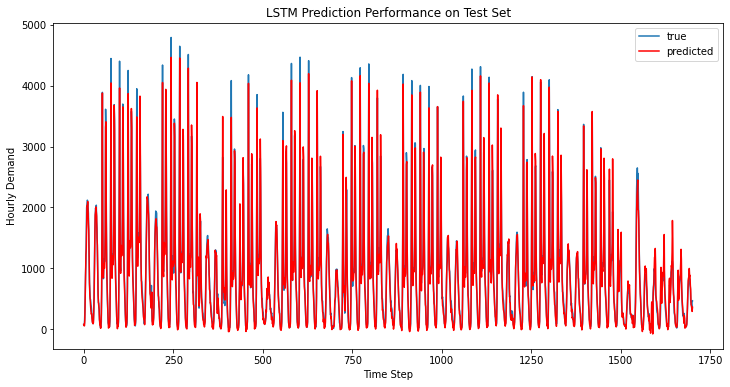

In [ ]:
# make prediction on th test set
y_pred_2 = model2.predict(X_test)

# apply inverse transformation at the independent value (hourly hires counts/demand)
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv_2 = cnt_transformer.inverse_transform(y_pred_2)

# plotting
plt.figure(figsize = (12, 6))
plt.plot(y_test_inv.flatten(), label = "true")
plt.plot(y_pred_inv_2.flatten(), "r", label = "predicted")
plt.ylabel("Hourly Demand")
plt.xlabel("Time Step")
plt.title("LSTM Prediction Performance on Test Set")
plt.legend()
plt.show()

In [ ]:
# evaluate GRU's performance & PrettyPrint
table = PrettyTable()
table.field_names = ["Model", "RMSE", "MEA", "R² score"]

# regression evalution metrics
RMSE = mean_squared_error(y_test, y_pred_2, squared = False)
MAE = mean_absolute_error(y_test, y_pred_2)
R2 = r2_score(y_test, y_pred_2)    

# print pretty table
table.add_row(["LSTM", format(RMSE, ".4f"), format(MAE, ".4f"), format(R2, ".4f")])
print(table)

+-------+--------+--------+----------+
| Model |  RMSE  |  MEA   | R² score |
+-------+--------+--------+----------+
|  LSTM | 0.1358 | 0.0885 |  0.9769  |
+-------+--------+--------+----------+


###### BiLSTM

In [ ]:
model3 = Sequential()
model3.add(Bidirectional(LSTM(units = 32, input_shape=(X_train.shape[1], X_train.shape[2]))))
model3.add(Dropout(rate = 0.2))
model3.add(Dense(units = 1))
model3.compile(loss = "mse", optimizer = "adam")

# add early stoping with patient 10 steps, monitoring validation loss and finally keep
# the model (in the latest time window) with the smallest validation error
early_stopping = EarlyStopping(monitor = "val_loss", mode = "min", patience = 10)

In [ ]:
# train our model model in 50 epochs, using early stopping with validation set the 10% of train set
history3 = model3.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_split = 0.1, callbacks = [early_stopping], shuffle = False)

Epoch 1/50
438/438 [==============================] - 8s 18ms/step - loss: 0.5035 - val_loss: 0.3672
Epoch 2/50
438/438 [==============================] - 7s 16ms/step - loss: 0.1917 - val_loss: 0.1262
Epoch 3/50
438/438 [==============================] - 7s 16ms/step - loss: 0.1157 - val_loss: 0.0901
Epoch 4/50
438/438 [==============================] - 7s 15ms/step - loss: 0.0921 - val_loss: 0.0714
Epoch 5/50
438/438 [==============================] - 7s 16ms/step - loss: 0.0753 - val_loss: 0.0564
Epoch 6/50
438/438 [==============================] - 7s 16ms/step - loss: 0.0612 - val_loss: 0.0434
Epoch 7/50
438/438 [==============================] - 7s 16ms/step - loss: 0.0535 - val_loss: 0.0447
Epoch 8/50
438/438 [==============================] - 7s 16ms/step - loss: 0.0485 - val_loss: 0.0310
Epoch 9/50
438/438 [==============================] - 7s 16ms/step - loss: 0.0439 - val_loss: 0.0281
Epoch 10/50
438/438 [==============================] - 7s 16ms/step - loss: 0.0412 - val_lo

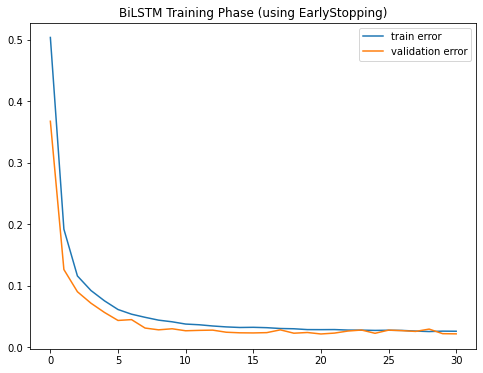

In [ ]:
plt.figure(figsize = (8, 6))
plt.title("BiLSTM Training Phase (using EarlyStopping)")
plt.plot(history3.history["loss"], label = "train error")
plt.plot(history3.history["val_loss"], label = "validation error")
plt.legend();

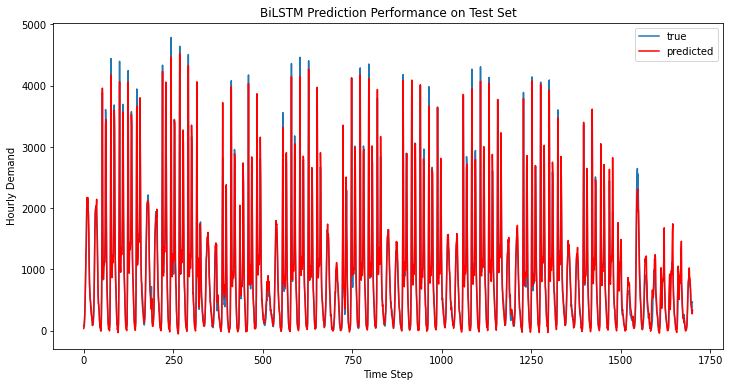

In [ ]:
# make prediction on th test set
y_pred_3 = model3.predict(X_test)

# apply inverse transformation at the independent value (hourly hires counts/demand)
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv_3 = cnt_transformer.inverse_transform(y_pred_3)

# plotting
plt.figure(figsize = (12, 6))
plt.plot(y_test_inv.flatten(), label = "true")
plt.plot(y_pred_inv_3.flatten(), "r", label = "predicted")
plt.ylabel("Hourly Demand")
plt.xlabel("Time Step")
plt.title("BiLSTM Prediction Performance on Test Set")
plt.legend()
plt.show()

In [ ]:
# evaluate GRU's performance & PrettyPrint
table = PrettyTable()
table.field_names = ["Model", "RMSE", "MEA", "R² score"]

# regression evalution metrics
RMSE = mean_squared_error(y_test, y_pred_3, squared = False)
MAE = mean_absolute_error(y_test, y_pred_3)
R2 = r2_score(y_test, y_pred_3)    

# print pretty table
table.add_row(["BiLSTM", format(RMSE, ".4f"), format(MAE, ".4f"), format(R2, ".4f")])
print(table)

+--------+--------+--------+----------+
| Model  |  RMSE  |  MEA   | R² score |
+--------+--------+--------+----------+
| BiLSTM | 0.1377 | 0.0882 |  0.9762  |
+--------+--------+--------+----------+


#### Clustering over Stations

##### Spatial Clustering by using k-means

In [ ]:
# data in which kmeans will based on
X = stations[["latitude", "longitude"]].values
k = range(1, 10)
kmean = [KMeans(n_clusters = i).fit(X) for i in k]

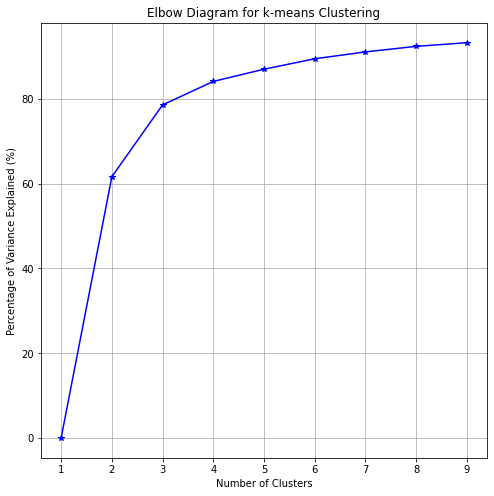

In [ ]:
# plot Elbow Diagram
def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, "euclidean") for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(k, bss/tss*100, "b*-")
    plt.grid(True)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Percentage of Variance Explained (%)")
    plt.title("Elbow Diagram for k-means Clustering")
    plt.show()


plot_elbow(kmean, X)

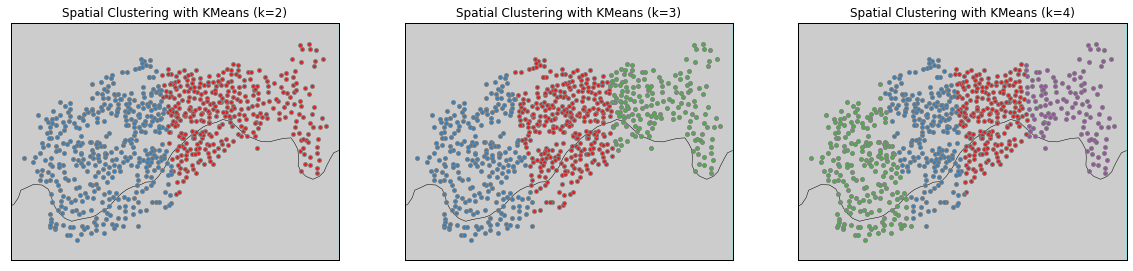

In [ ]:
def plot_stations_map(ax, stns):
    # determine range to print based on min, max lat and lon of the data
    lat = list(stns["station_latitude"])
    lon = list(stns["station_longitude"])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    # create map using BASEMAP
    m = Basemap(llcrnrlon = lon_min,
                llcrnrlat = lat_min,
                urcrnrlon = lon_max,
                urcrnrlat = lat_max,
                lat_0 = (lat_max - lat_min)/2,
                lon_0 = (lon_max - lon_min)/2,
                projection = "lcc",
                resolution = "f",)

    m.drawcoastlines()
    m.fillcontinents(lake_color = "aqua")
    m.drawmapboundary(fill_color = "aqua")
    m.drawrivers()    
    
    # plot points
    clist = list(stns["cluster"].unique())
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, max(10, k))))
    for i in range(k):
        color = next(colors)
        df = stns.loc[stns["cluster"] == clist[i]]        
        
        # convert lat and lon to map projection coordinates
        lons, lats = m(list(df['station_longitude']), list(df['station_latitude']))        
        ax.scatter(lons, lats, marker = "o", color = color, edgecolor = "gray", zorder = 5, alpha = 1.0, s = 15)

# based on above elbow diagram => k = 2, 3 or 4 clusters
k = [2, 3, 4]
plt.subplots(nrows = 1, ncols = 3, figsize=(20, 10))

for i in range(len(k)):
    estimator = kmean[k[i]-1]
    mini_stations["cluster"] = estimator.predict(X).tolist()
    
    ax = plt.subplot(1, 3, i+1)
    ax.set_title("Spatial Clustering with KMeans (k={})".format(k[i]))

    plot_stations_map(ax, mini_stations)

##### Spatial Clustering using DBSCAN

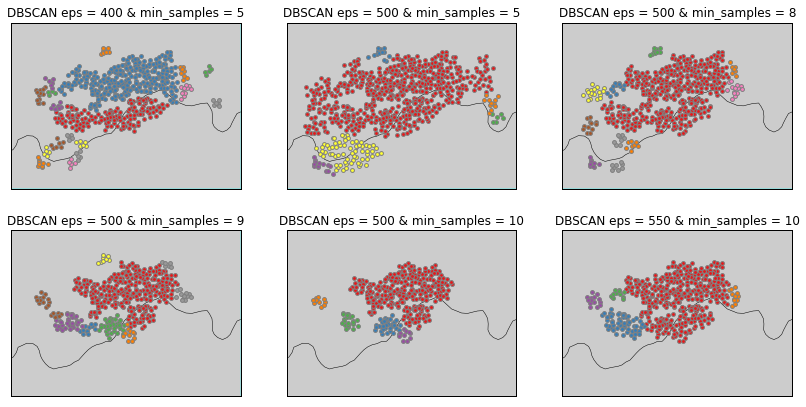

In [ ]:
def haversine_distance(x, y):
    lat1, lon1 = x[0], x[1]
    lat2, lon2 = y[0], y[1]
    return vincenty((lat1, lon1), (lat2, lon2)).meters


plt.subplots(nrows = 2, ncols = 3, figsize = (14, 7))

# final optimal results!!
# after examing a lot of different cases
estimator = DBSCAN(eps = 400, min_samples = 5, metric = haversine_distance).fit(X)
mini_stations["cluster"] = estimator.labels_.tolist()
ax = plt.subplot(2,3,1)
ax.set_title("DBSCAN eps = 400 & min_samples = 5"); plot_stations_map(ax, mini_stations)

estimator = DBSCAN(eps = 500, min_samples = 5, metric = haversine_distance).fit(X)
mini_stations["cluster"] = estimator.labels_.tolist()
ax = plt.subplot(2,3,2)
ax.set_title("DBSCAN eps = 500 & min_samples = 5"); plot_stations_map(ax, mini_stations)

estimator = DBSCAN(eps = 500, min_samples = 8, metric = haversine_distance).fit(X)
mini_stations["cluster"] = estimator.labels_.tolist()
ax = plt.subplot(2,3,3)
ax.set_title("DBSCAN eps = 500 & min_samples = 8"); plot_stations_map(ax, mini_stations)

estimator = DBSCAN(eps = 500, min_samples = 9, metric = haversine_distance).fit(X)
mini_stations["cluster"] = estimator.labels_.tolist()
ax = plt.subplot(2,3,4)
ax.set_title("DBSCAN eps = 500 & min_samples = 9"); plot_stations_map(ax, mini_stations)

estimator = DBSCAN(eps = 500, min_samples = 10, metric = haversine_distance).fit(X)
mini_stations["cluster"] = estimator.labels_.tolist()
ax = plt.subplot(2,3,5)
ax.set_title("DBSCAN eps = 500 & min_samples = 10"); plot_stations_map(ax, mini_stations)

estimator = DBSCAN(eps = 550, min_samples = 10, metric = haversine_distance).fit(X)
mini_stations["cluster"] = estimator.labels_.tolist()
ax = plt.subplot(2,3,6)
ax.set_title("DBSCAN eps = 550 & min_samples = 10"); plot_stations_map(ax, mini_stations)